In [19]:
import pandas as pd

import numpy as np

#import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context = 'notebook', #mostly controls relative sizes of things on plot #The base context is “notebook”, and the other contexts are “paper”, “talk”, and “poster”
        style = 'darkgrid', #dict, None, or one of {darkgrid, whitegrid, dark, white, ticks}
        palette = 'deep', # Should be something that color_palette() can process.
        font_scale = 1, 
        color_codes = False, 
        rc = None)

# from IPython.core.interactiveshell import InteractiveShell 
# InteractiveShell.ast_node_interactivity = 'last_expr' #s etting = "all" allows multiple outputs to be displayed for a given input cell. don't use w plotting!

from IPython.display import display

%matplotlib notebook
#%matplotlib inline

pd.__version__, sns.__version__ , np.__version__ #,  matplotlib.__version__

('0.23.3', '0.9.0', '1.14.2')

In [4]:
# some functions to load

def head_with_full_columns(pd_in, row_amount = 5):
    with pd.option_context('display.max_columns', len(pd_in.iloc[0])):
        display(pd_in[:row_amount])
        
def balanced_sample(df_in, total_size, rand_state):
    s0 = df_in[df_in['TARGET']==0].sample(n = total_size//2, random_state = rand_state)
    s1 = df_in[df_in['TARGET']==1].sample(n = total_size//2, random_state = rand_state)
    new_df = pd.concat([s0,s1])
    new_df.sort_index(inplace = True)
    return new_df

def which_df(feature):
    if feature in application_train_df_f_list:
        return feature, 'application_train_df'
    
    if feature in bureau_df_f_list:
        return feature, 'bureau_df'
        
    if feature in bureau_balance_df_f_list:
        return feature, 'bureau_balance_df'
        
    if feature in credit_card_balance_df_f_list:
        return feature, 'credit_card_balance_df'
    
    if feature in installments_payments_df_f_list:
        return feature, 'installments_payments_df'
        
    if feature in POS_CASH_balance_df_f_list:
        return feature, 'POS_CASH_balance_df'
        
    if feature in previous_application_df_f_list:
        return feature, 'previous_application_df'

In [260]:
# have to watch some feats with many zeros, sometimes they are just mostly 0, sometimes if you take away the zeros, there is some information there. 
# bin on ever overdue

# there is one feature at least that only appears for some people, I can start with that and base a score around it. 

# look at all the values NOT 0 or the median etc. 

# NON aggregated dataframe exploration/  plots

In [4]:
bureau_df = pd.read_csv('bureau.csv')#, index_col = 'SK_ID_CURR')
# replace NaNs in object entries for now is pretty safe. 
f_list = list(bureau_df.select_dtypes('object').columns)
bureau_df[f_list] = bureau_df[f_list].fillna(value = 'NA')
# AMT_ANNUITY appears in multiple files, so rename more specifically. 
bureau_df.rename( columns = {"AMT_ANNUITY":"AMT_ANNUITY_from_bureau"} , inplace=True)# index = str,
del f_list

In [8]:
bureau_df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
SK_ID_CURR                 1716428 non-null int64
SK_ID_BUREAU               1716428 non-null int64
CREDIT_ACTIVE              1716428 non-null object
CREDIT_CURRENCY            1716428 non-null object
DAYS_CREDIT                1716428 non-null int64
CREDIT_DAY_OVERDUE         1716428 non-null int64
DAYS_CREDIT_ENDDATE        1610875 non-null float64
DAYS_ENDDATE_FACT          1082775 non-null float64
AMT_CREDIT_MAX_OVERDUE     591940 non-null float64
CNT_CREDIT_PROLONG         1716428 non-null int64
AMT_CREDIT_SUM             1716415 non-null float64
AMT_CREDIT_SUM_DEBT        1458759 non-null float64
AMT_CREDIT_SUM_LIMIT       1124648 non-null float64
AMT_CREDIT_SUM_OVERDUE     1716428 non-null float64
CREDIT_TYPE                1716428 non-null object
DAYS_CREDIT_UPDATE         1716428 non-null int64
AMT_ANNUITY_from_bureau    489637 non-null float64
dtypes: float64(8), 

In [5]:
#load this df for some things. 
app_feats_to_import = [
'SK_ID_CURR',
'TARGET',
'CODE_GENDER', 
#'FLAG_OWN_CAR',
# #'FLAG_OWN_REALTY',              
# #'CNT_CHILDREN',
# 'AMT_INCOME_TOTAL',
# 'AMT_CREDIT',
# 'AMT_ANNUITY_from_app_train',
# 'AMT_GOODS_PRICE',
# #'NAME_TYPE_SUITE',
#'NAME_INCOME_TYPE',
#'NAME_EDUCATION_TYPE',
#'NAME_FAMILY_STATUS',
# #'NAME_HOUSING_TYPE',
# #'REGION_POPULATION_RELATIVE',
# 'DAYS_BIRTH',
# 'DAYS_EMPLOYED',
# 'DAYS_REGISTRATION',
# #'DAYS_ID_PUBLISH',
# #'OWN_CAR_AGE',
#'OCCUPATION_TYPE',
#'CNT_FAM_MEMBERS',
#'REGION_RATING_CLIENT',
# #'REGION_RATING_CLIENT_W_CITY',
# #'WEEKDAY_APPR_PROCESS_START',
# #'REG_REGION_NOT_LIVE_REGION',
# #'REG_REGION_NOT_WORK_REGION',
# #'LIVE_REGION_NOT_WORK_REGION',
# #'REG_CITY_NOT_LIVE_CITY',
# #'REG_CITY_NOT_WORK_CITY',
# #'LIVE_CITY_NOT_WORK_CITY',
# 'EXT_SOURCE_1',
# 'EXT_SOURCE_2',
# 'EXT_SOURCE_3' 
]

app_train_very_short = pd.read_csv('application_train_df_final.csv', usecols = app_feats_to_import, index_col = 'SK_ID_CURR')

del app_feats_to_import

In [6]:
bureau_wTargets_df = pd.merge(bureau_df, app_train_very_short, on  = 'SK_ID_CURR', how = 'left')

In [7]:
bureau_wTargets_df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1716428 entries, 0 to 1716427
Data columns (total 19 columns):
SK_ID_CURR                 1716428 non-null int64
SK_ID_BUREAU               1716428 non-null int64
CREDIT_ACTIVE              1716428 non-null object
CREDIT_CURRENCY            1716428 non-null object
DAYS_CREDIT                1716428 non-null int64
CREDIT_DAY_OVERDUE         1716428 non-null int64
DAYS_CREDIT_ENDDATE        1610875 non-null float64
DAYS_ENDDATE_FACT          1082775 non-null float64
AMT_CREDIT_MAX_OVERDUE     591940 non-null float64
CNT_CREDIT_PROLONG         1716428 non-null int64
AMT_CREDIT_SUM             1716415 non-null float64
AMT_CREDIT_SUM_DEBT        1458759 non-null float64
AMT_CREDIT_SUM_LIMIT       1124648 non-null float64
AMT_CREDIT_SUM_OVERDUE     1716428 non-null float64
CREDIT_TYPE                1716428 non-null object
DAYS_CREDIT_UPDATE         1716428 non-null int64
AMT_ANNUITY_from_bureau    489637 non-null float64
TARGET              

In [17]:
len(np.unique(app_train_very_short.index.values)), len(np.unique(bureau_wTargets_df['SK_ID_CURR'].values))

(307511, 305811)

In [7]:
bureau_wTargets_df.dtypes

SK_ID_CURR                   int64
SK_ID_BUREAU                 int64
CREDIT_ACTIVE               object
CREDIT_CURRENCY             object
DAYS_CREDIT                  int64
CREDIT_DAY_OVERDUE           int64
DAYS_CREDIT_ENDDATE        float64
DAYS_ENDDATE_FACT          float64
AMT_CREDIT_MAX_OVERDUE     float64
CNT_CREDIT_PROLONG           int64
AMT_CREDIT_SUM             float64
AMT_CREDIT_SUM_DEBT        float64
AMT_CREDIT_SUM_LIMIT       float64
AMT_CREDIT_SUM_OVERDUE     float64
CREDIT_TYPE                 object
DAYS_CREDIT_UPDATE           int64
AMT_ANNUITY_from_bureau    float64
TARGET                     float64
CODE_GENDER                 object
dtype: object

In [8]:
# get a random sample bc full sample is too much to plot
bureau_wTargets_sample = balanced_sample(bureau_wTargets_df, 24000, 0)

these_types = bureau_wTargets_df.dtypes

## categorical features

<IPython.core.display.Javascript object>


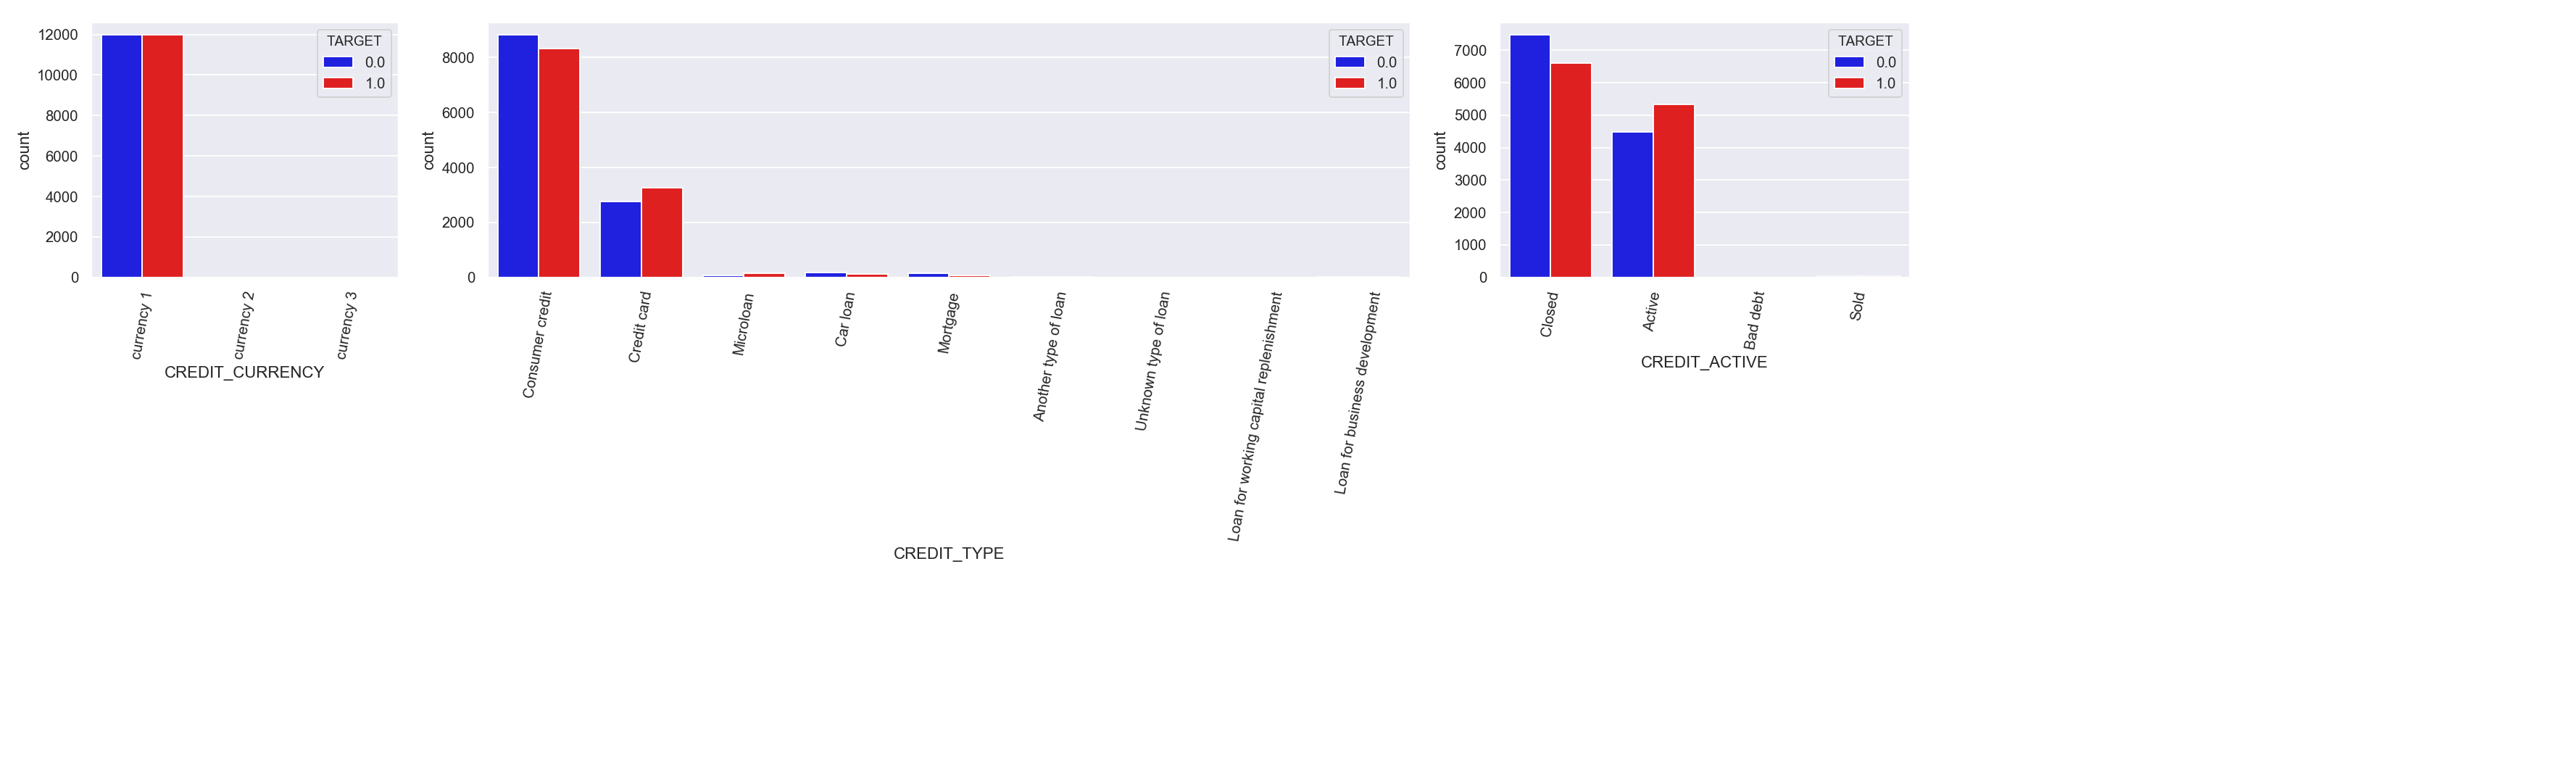

In [9]:
# PLOT CATEGORICAL FEATURES BINNED

# get categorical features
feats = list(   set(  these_types[these_types == 'object'].index ) - {'TARGET', 'CODE_GENDER'} )

# number of values for each feature for plot sizing
ratios = [len(np.unique(bureau_wTargets_sample[f])) for f in feats]
tot_width = sum(ratios)/.8

fig, axs = plt.subplots(nrows = 1,
                        ncols = len(feats),
                        gridspec_kw = {'width_ratios':ratios},
                        figsize = (tot_width, 6));

for f, a in zip(feats, range(len(feats))):
    g = sns.countplot(x = f,
                      hue = "TARGET", 
                      data = bureau_wTargets_sample, 
                      palette = ['blue','red'], 
                      #bw = 1,
                      ax = axs[a]
                       );
    g.set_xticklabels(g.get_xticklabels(), 
                      rotation = 80);

plt.tight_layout()

## plot float features

<IPython.core.display.Javascript object>


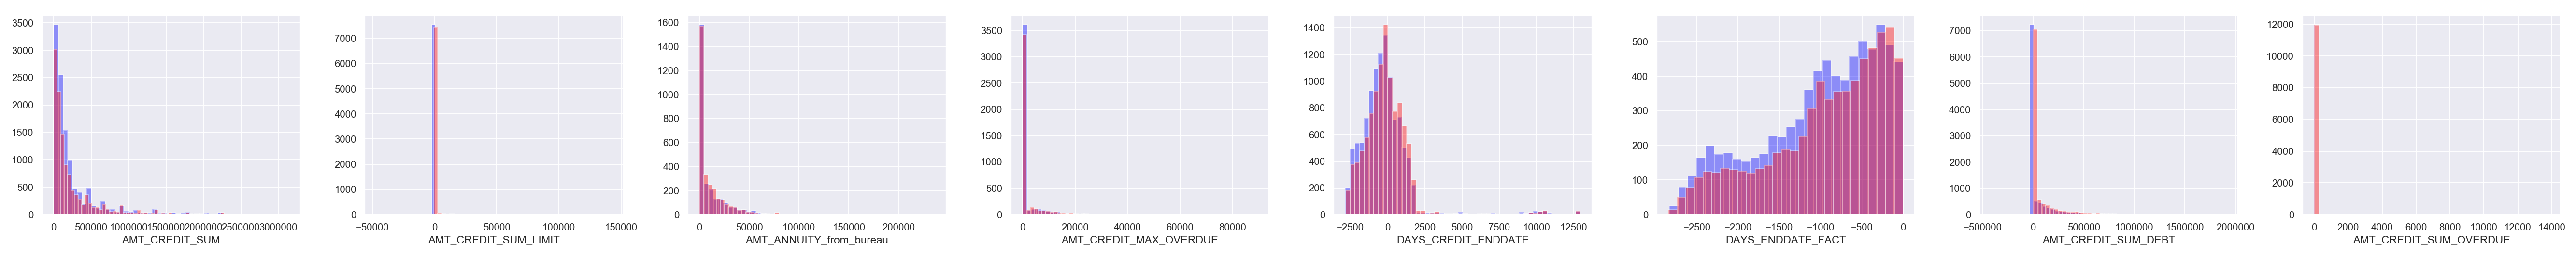

In [11]:
# PLOT FLOAT FEATURES

# get float features
my_list = list(   set(  these_types[these_types == 'float'].index ) - {'TARGET', 'CODE_GENDER'} )
num_plots = len(my_list)

fig, axs = plt.subplots(nrows = 1,
                        ncols = num_plots,
                        figsize = (num_plots*5,  4));

for f, a in zip(my_list, range(len(my_list))):
    
    dat_0 = bureau_wTargets_sample[ (bureau_wTargets_sample['TARGET']== 0) & (bureau_wTargets_sample[f].notna())][f]
    dat_1 = bureau_wTargets_sample[ (bureau_wTargets_sample['TARGET']== 1) & (bureau_wTargets_sample[f].notna())][f]
    
    #keep data within 3 SDs of mean
    dat_0 = dat_0[~((dat_0-dat_0.mean()).abs() > 3*dat_0.std())]
    dat_1 = dat_1[~((dat_1-dat_1.mean()).abs() > 3*dat_1.std())]
    
#     #divv = 40
#     bw_0 = np.std(dat_0)/3
#     bw_1 = np.std(dat_1)/3
    
    g0 = sns.distplot(dat_0, color = 'blue', ax = axs[a], kde = False)#, bw =bw_0) #( abs(max(dat_0)- min(dat_0))/divv   ) )#, bw = 90000)
    g1 = sns.distplot(dat_1, color = 'red',  ax = axs[a],kde = False)#, bw =bw_1) #( abs(max(dat_0)- min(dat_0))/divv       ) )#,   ) #, bw = 90000)
    
#     if f =='AMT_CREDIT_SUM_max':
#         #g1.set_ylim(10**4.3, 10**7)
#         g1.set_xlim(1, 10**7)
    
   # g0.set_xticklabels(g.get_xticklabels(),rotation = 80)

plt.tight_layout()

In [127]:
# low risk group
bureau_wTargets_df[bureau_wTargets_df['AMT_CREDIT_SUM_LIMIT']<0]['TARGET'].value_counts()

0.0    280
1.0     71
Name: TARGET, dtype: int64

In [96]:
#high risk group
bureau_wTargets_sample[bureau_wTargets_sample['AMT_CREDIT_SUM_OVERDUE']!=0]['TARGET'].value_counts()

1.0    63
0.0    27
Name: TARGET, dtype: int64

## plot log float features

In [54]:
bureau_wTargets_sample['Log_AMT_CREDIT_SUM'] = np.log10(bureau_wTargets_sample['AMT_CREDIT_SUM']+1)
bureau_wTargets_sample['LogPos_AMT_CREDIT_SUM_LIMIT'] = np.log10(bureau_wTargets_sample[bureau_wTargets_sample['AMT_CREDIT_SUM_LIMIT']>0]['AMT_CREDIT_SUM_LIMIT'])
bureau_wTargets_sample['Log_AMT_ANNUITY_from_bureau'] = np.log10(bureau_wTargets_sample['AMT_ANNUITY_from_bureau']+1)
bureau_wTargets_sample['Log_AMT_CREDIT_MAX_OVERDUE'] = np.log10(bureau_wTargets_sample['AMT_CREDIT_MAX_OVERDUE']+1)
bureau_wTargets_sample['LogPos_AMT_CREDIT_SUM_DEBT'] = np.log10(bureau_wTargets_sample[bureau_wTargets_sample['AMT_CREDIT_SUM_DEBT']>0]['AMT_CREDIT_SUM_DEBT'])
bureau_wTargets_sample['Log_AMT_CREDIT_SUM_OVERDUE'] = np.log10(bureau_wTargets_sample['AMT_CREDIT_SUM_OVERDUE']+1)

<IPython.core.display.Javascript object>


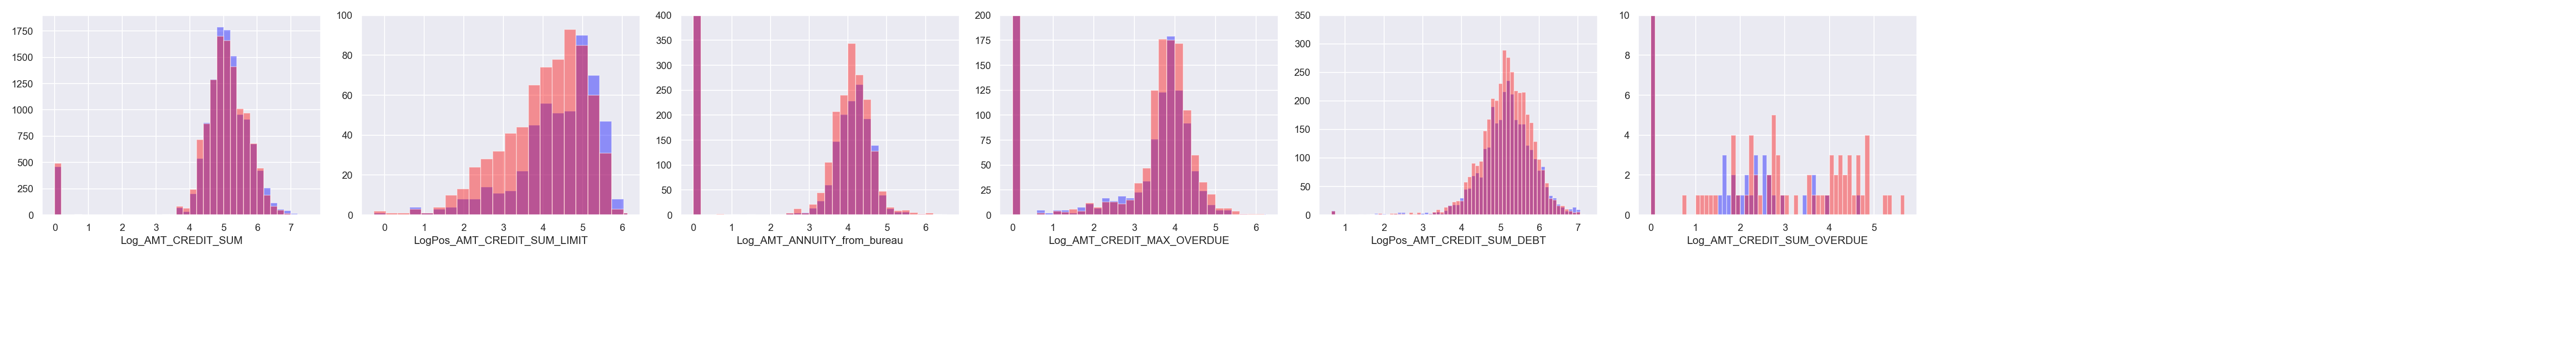

In [98]:
# PLOT LOG FLOAT FEATURES

# get float features
my_list = ['Log_AMT_CREDIT_SUM','LogPos_AMT_CREDIT_SUM_LIMIT','Log_AMT_ANNUITY_from_bureau','Log_AMT_CREDIT_MAX_OVERDUE','LogPos_AMT_CREDIT_SUM_DEBT','Log_AMT_CREDIT_SUM_OVERDUE' ]
num_plots = len(my_list)

fig, axs = plt.subplots(nrows = 1,
                        ncols = num_plots,
                        figsize = (num_plots*5,  4));

bin_widths = [.2,.3,.2,.2,.1,.1]
ymaxs = [1900,100,400,200,350,10]

for f, a, bw, yl in zip(my_list, range(len(my_list)), bin_widths, ymaxs):
    
    dat_0 = bureau_wTargets_sample[ (bureau_wTargets_sample['TARGET']== 0) & (bureau_wTargets_sample[f].notna())][f]
    dat_1 = bureau_wTargets_sample[ (bureau_wTargets_sample['TARGET']== 1) & (bureau_wTargets_sample[f].notna())][f]
    
    #keep data within 3 SDs of mean
   # dat_0 = dat_0[~((dat_0-dat_0.mean()).abs() > 3*dat_0.std())]
   # dat_1 = dat_1[~((dat_1-dat_1.mean()).abs() > 3*dat_1.std())]
    
#     #divv = 40
#     bw_0 = np.std(dat_0)/3
#     bw_1 = np.std(dat_1)/3
    
    mn = min( min(dat_0), min(dat_1)   )
    mx = max( max(dat_0), max(dat_1)   )
    my_bins = list(np.arange(mn,mx,bw)) +[mx]
    
    g0 = sns.distplot(dat_0, color = 'blue', ax = axs[a], kde = False, bins = my_bins)#, bw =bw_0) #( abs(max(dat_0)- min(dat_0))/divv   ) )#, bw = 90000)
    g1 = sns.distplot(dat_1, color = 'red',  ax = axs[a],kde = False, bins = my_bins)#, bw =bw_1) #( abs(max(dat_0)- min(dat_0))/divv       ) )#,   ) #, bw = 90000)
    

    g1.set_ylim(0, yl)
    # g1.set_xlim(1, 10**7)

    
   # g0.set_xticklabels(g.get_xticklabels(),rotation = 80)

plt.tight_layout()

## plot int features

<IPython.core.display.Javascript object>


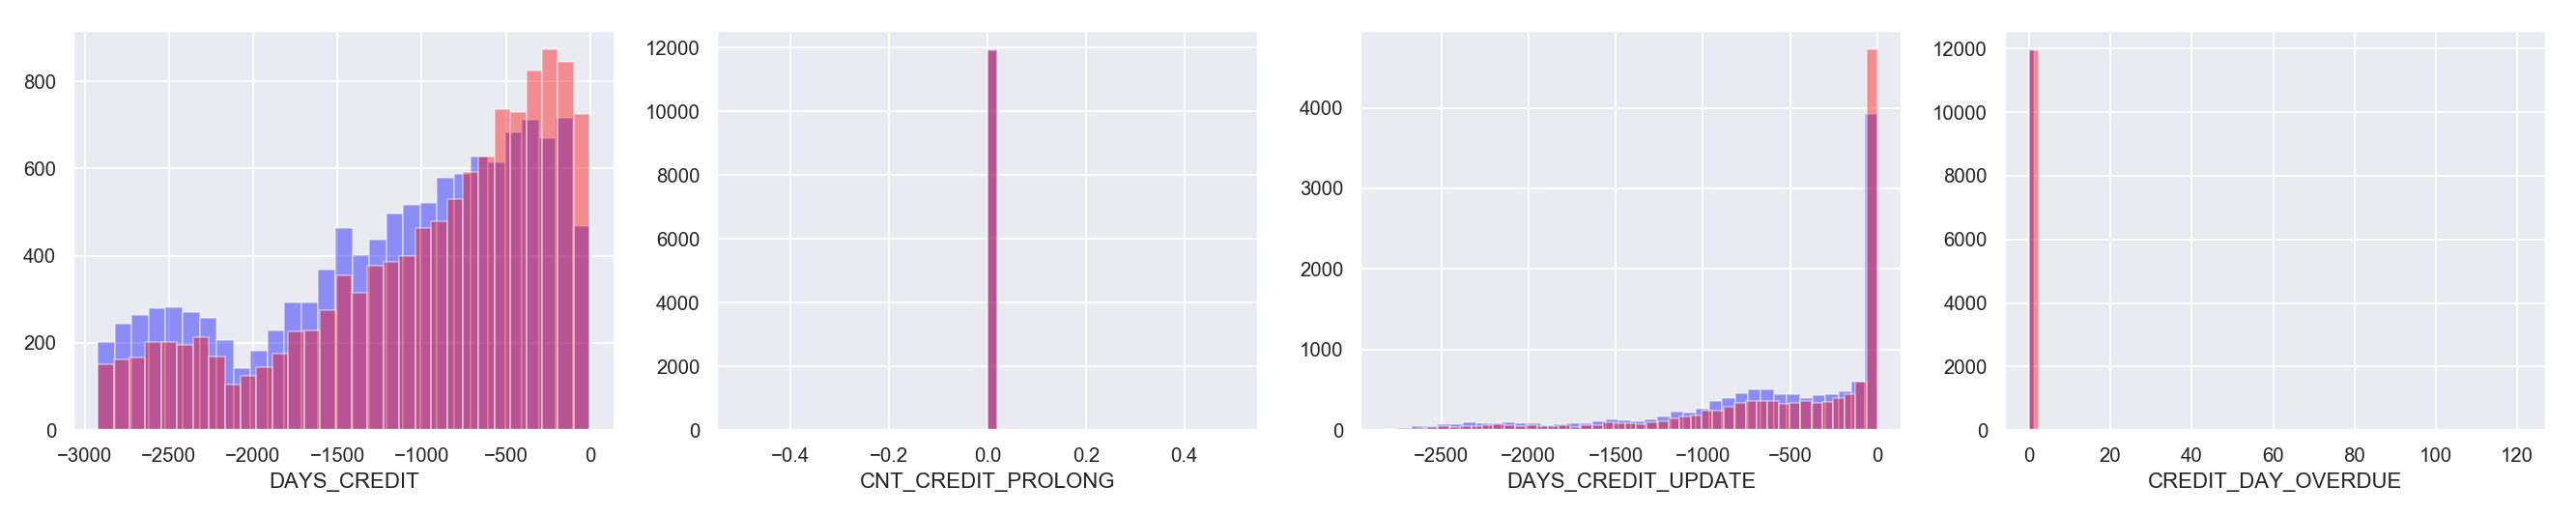

In [99]:
# PLOT INT FEATURES

# get int features

my_list = list(   set(  these_types[these_types == 'int'].index ) - {'SK_ID_CURR','SK_ID_BUREAU'})
num_plots = len(my_list)

fig, axs = plt.subplots(nrows = 1,
                        ncols = num_plots,
                        figsize = (num_plots*5,  4));

for f, a in zip(my_list, range(len(my_list))):

    dat_0 = bureau_wTargets_sample[ (bureau_wTargets_sample['TARGET']== 0) & (bureau_wTargets_sample[f].notna())][f]
    dat_1 = bureau_wTargets_sample[ (bureau_wTargets_sample['TARGET']== 1) & (bureau_wTargets_sample[f].notna())][f]
    
    #keep data within 3 SDs of mean
    dat_0 = dat_0[~((dat_0-dat_0.mean()).abs() > 3*dat_0.std())]
    dat_1 = dat_1[~((dat_1-dat_1.mean()).abs() > 3*dat_1.std())]
    
#     #divv = 40
#     bw_0 = np.std(dat_0)/3
#     bw_1 = np.std(dat_1)/3
    
    g0 = sns.distplot(dat_0, color = 'blue', ax = axs[a], kde = False)#, bw =bw_0) #( abs(max(dat_0)- min(dat_0))/divv   ) )#, bw = 90000)
    g1 = sns.distplot(dat_1, color = 'red',  ax = axs[a],kde = False)#, bw =bw_1) #( abs(max(dat_0)- min(dat_0))/divv       ) )#,   ) #, bw = 90000)
    
#     if f =='AMT_CREDIT_SUM_max':
#         #g1.set_ylim(10**4.3, 10**7)
#         g1.set_xlim(1, 10**7)
    
   # g0.set_xticklabels(g.get_xticklabels(),rotation = 80)

plt.tight_layout()

In [105]:
bureau_wTargets_sample[bureau_wTargets_sample['CNT_CREDIT_PROLONG']!=0]['TARGET'].value_counts()

1.0    84
0.0    69
Name: TARGET, dtype: int64

In [108]:
# this is a high risk group, but small. 
bureau_wTargets_sample[bureau_wTargets_sample['CREDIT_DAY_OVERDUE']!=0]['TARGET'].value_counts()

1.0    61
0.0    27
Name: TARGET, dtype: int64

In [122]:
bureau_wTargets_sample['LogNeg_DAYS_CREDIT_UPDATE'] = np.log10(-bureau_wTargets_sample['DAYS_CREDIT_UPDATE']+1)

<IPython.core.display.Javascript object>


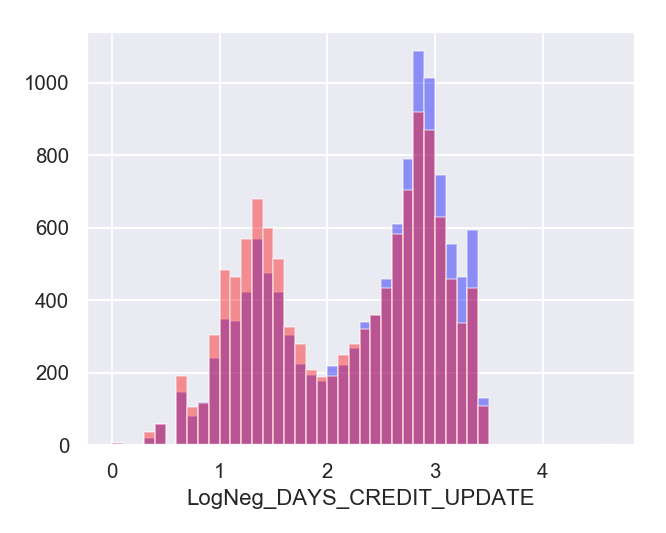

In [126]:
# PLOT LOG INT FEATUR

# get int features
f = 'LogNeg_DAYS_CREDIT_UPDATE'

fig, axs = plt.subplots(nrows = 1,
                        ncols = 1,
                        figsize = (5,  4));

dat_0 = bureau_wTargets_sample[ (bureau_wTargets_sample['TARGET']== 0) & (bureau_wTargets_sample[f].notna())][f]
dat_1 = bureau_wTargets_sample[ (bureau_wTargets_sample['TARGET']== 1) & (bureau_wTargets_sample[f].notna())][f]
    
    #keep data within 3 SDs of mean
dat_0 = dat_0[~((dat_0-dat_0.mean()).abs() > 3*dat_0.std())]
dat_1 = dat_1[~((dat_1-dat_1.mean()).abs() > 3*dat_1.std())]
    
#     #divv = 40
#     bw_0 = np.std(dat_0)/3
#     bw_1 = np.std(dat_1)/3
    
mn = min( min(dat_0), min(dat_1)   )
mx = max( max(dat_0), max(dat_1)   )
my_bins = list(np.arange(mn,mx,.1)) +[mx]    
    
g0 = sns.distplot(dat_0, color = 'blue', ax = axs, kde = False, bins = my_bins)#, bw =bw_0) #( abs(max(dat_0)- min(dat_0))/divv   ) )#, bw = 90000)
g1 = sns.distplot(dat_1, color = 'red',  ax = axs,kde = False, bins = my_bins)#, bw =bw_1) #( abs(max(dat_0)- min(dat_0))/divv       ) )#,   ) #, bw = 90000)
    
#     if f =='AMT_CREDIT_SUM_max':
#         #g1.set_ylim(10**4.3, 10**7)
#         g1.set_xlim(1, 10**7)
    
   # g0.set_xticklabels(g.get_xticklabels(),rotation = 80)

plt.tight_layout()

# Load Dataframes for aggregated data. 

In [4]:
# bureau_df = pd.read_csv('bureau.csv')#, index_col = 'SK_ID_CURR')
# # replace NaNs in object entries for now is pretty safe. 
# f_list = list(bureau_df.select_dtypes('object').columns)
# bureau_df[f_list] = bureau_df[f_list].fillna(value = 'NA')
# # AMT_ANNUITY appears in multiple files, so rename more specifically. 
# bureau_df.rename( columns = {"AMT_ANNUITY":"AMT_ANNUITY_from_bureau"} , inplace=True)# index = str,

# del f_list

In [5]:
pwd

'/Users/DonBunk/Desktop/Google Drive/data_science/Python_Projects/Home_Credit_Default_Risk'

In [6]:
cd '/Users/DonBunk/Desktop/Google Drive/data_science/Python_Projects/Home_Credit_Default_Risk/'

/Users/DonBunk/Desktop/Google Drive/data_science/Python_Projects/Home_Credit_Default_Risk


In [8]:
path = 'aggregation/'
bureau_df_aggregated_final_df = pd.read_csv(path + 'bureau_df_aggregated_final.csv', index_col='SK_ID_CURR')

In [10]:
#load this df for some things. leave this loaded to subtract off later
app_feats_to_import = [
'SK_ID_CURR',
'TARGET',
'CODE_GENDER', 
'FLAG_OWN_CAR',
# #'FLAG_OWN_REALTY',              
# #'CNT_CHILDREN',
# 'AMT_INCOME_TOTAL',
# 'AMT_CREDIT',
# 'AMT_ANNUITY_from_app_train',
# 'AMT_GOODS_PRICE',
# #'NAME_TYPE_SUITE',
'NAME_INCOME_TYPE',
'NAME_EDUCATION_TYPE',
'NAME_FAMILY_STATUS',
# #'NAME_HOUSING_TYPE',
# #'REGION_POPULATION_RELATIVE',
# 'DAYS_BIRTH',
# 'DAYS_EMPLOYED',
# 'DAYS_REGISTRATION',
# #'DAYS_ID_PUBLISH',
# #'OWN_CAR_AGE',
'OCCUPATION_TYPE',
'CNT_FAM_MEMBERS',
'REGION_RATING_CLIENT',
# #'REGION_RATING_CLIENT_W_CITY',
# #'WEEKDAY_APPR_PROCESS_START',
# #'REG_REGION_NOT_LIVE_REGION',
# #'REG_REGION_NOT_WORK_REGION',
# #'LIVE_REGION_NOT_WORK_REGION',
# #'REG_CITY_NOT_LIVE_CITY',
# #'REG_CITY_NOT_WORK_CITY',
# #'LIVE_CITY_NOT_WORK_CITY',
# 'EXT_SOURCE_1',
# 'EXT_SOURCE_2',
# 'EXT_SOURCE_3' 
]

path = 'wrangling/' 

app_train_short = pd.read_csv(path+'application_train_df_final.csv', usecols = app_feats_to_import, index_col = 'SK_ID_CURR')

#del app_feats_to_import

In [11]:
bureau_df_aggregated_final_df.info(verbose = True, null_counts = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 305811 entries, 100001 to 456255
Data columns (total 51 columns):
DAYS_CREDIT_ENDDATE_mean          303226 non-null float64
DAYS_CREDIT_ENDDATE_median        303226 non-null float64
DAYS_CREDIT_ENDDATE_max           303226 non-null float64
DAYS_CREDIT_ENDDATE_min           303226 non-null float64
DAYS_ENDDATE_FACT_mean            268155 non-null float64
DAYS_ENDDATE_FACT_median          268155 non-null float64
DAYS_ENDDATE_FACT_max             268155 non-null float64
DAYS_ENDDATE_FACT_min             268155 non-null float64
AMT_CREDIT_MAX_OVERDUE_mean       212971 non-null float64
AMT_CREDIT_MAX_OVERDUE_median     212971 non-null float64
AMT_CREDIT_MAX_OVERDUE_max        212971 non-null float64
AMT_CREDIT_MAX_OVERDUE_min        212971 non-null float64
AMT_CREDIT_SUM_mean               305809 non-null float64
AMT_CREDIT_SUM_median             305809 non-null float64
AMT_CREDIT_SUM_max                305809 non-null float64
AMT_CREDIT_SUM

In [12]:
bureau_aggregated_final_df_wTargets_df = pd.merge(app_train_short, bureau_df_aggregated_final_df, on  = 'SK_ID_CURR', how = 'left')

# replace NaNs in object entries for now is pretty safe. 
f_list = list(bureau_aggregated_final_df_wTargets_df.select_dtypes('object').columns)
bureau_aggregated_final_df_wTargets_df[f_list] = bureau_aggregated_final_df_wTargets_df[f_list].fillna(value = 'NA')

# preliminary cleansing for plotting

## get rid of one annoying DAYS_CREDIT_UPDATE_mean >0. I just drop it bc this isn't something I anticipate on a regular basis in final data.

In [13]:
# there is this one damn value that is postive and all the rest are neg. 
# I will just drop it. 

In [14]:
bureau_aggregated_final_df_wTargets_df[bureau_aggregated_final_df_wTargets_df['DAYS_CREDIT_UPDATE_mean']>0][['DAYS_CREDIT_UPDATE_mean']]

DAYS_CREDIT_UPDATE_mean
SK_ID_CURR                         
243211                         14.0

In [15]:
bureau_aggregated_final_df_wTargets_df.drop(index = 243211, axis = 1, inplace=True)

In [16]:
bureau_aggregated_final_df_wTargets_df[bureau_aggregated_final_df_wTargets_df['DAYS_CREDIT_UPDATE_mean']>0][['DAYS_CREDIT_UPDATE_mean']]

Empty DataFrame
Columns: [DAYS_CREDIT_UPDATE_mean]
Index: []

# preliminary information

## correlation

In [17]:
tar_corrs = bureau_aggregated_final_df_wTargets_df.corr()['TARGET']
tar_corrs_abs = tar_corrs.apply(abs)
tar_corrs_abs.sort_values()[-20:]

DAYS_ENDDATE_FACT_max         0.019644
AMT_CREDIT_SUM_max            0.019736
AMT_CREDIT_SUM_mean           0.019953
DAYS_CREDIT_UPDATE_max        0.028234
DAYS_CREDIT_ENDDATE_min       0.034283
DAYS_CREDIT_ENDDATE_max       0.036589
DAYS_CREDIT_ENDDATE_median    0.039930
DAYS_CREDIT_UPDATE_min        0.042865
DAYS_CREDIT_ENDDATE_mean      0.046983
DAYS_CREDIT_max               0.049782
DAYS_ENDDATE_FACT_median      0.050603
DAYS_ENDDATE_FACT_mean        0.053200
DAYS_ENDDATE_FACT_min         0.055887
REGION_RATING_CLIENT          0.058899
DAYS_CREDIT_UPDATE_median     0.067340
DAYS_CREDIT_UPDATE_mean       0.068929
DAYS_CREDIT_min               0.075250
DAYS_CREDIT_median            0.085415
DAYS_CREDIT_mean              0.089731
TARGET                        1.000000
Name: TARGET, dtype: float64

<IPython.core.display.Javascript object>


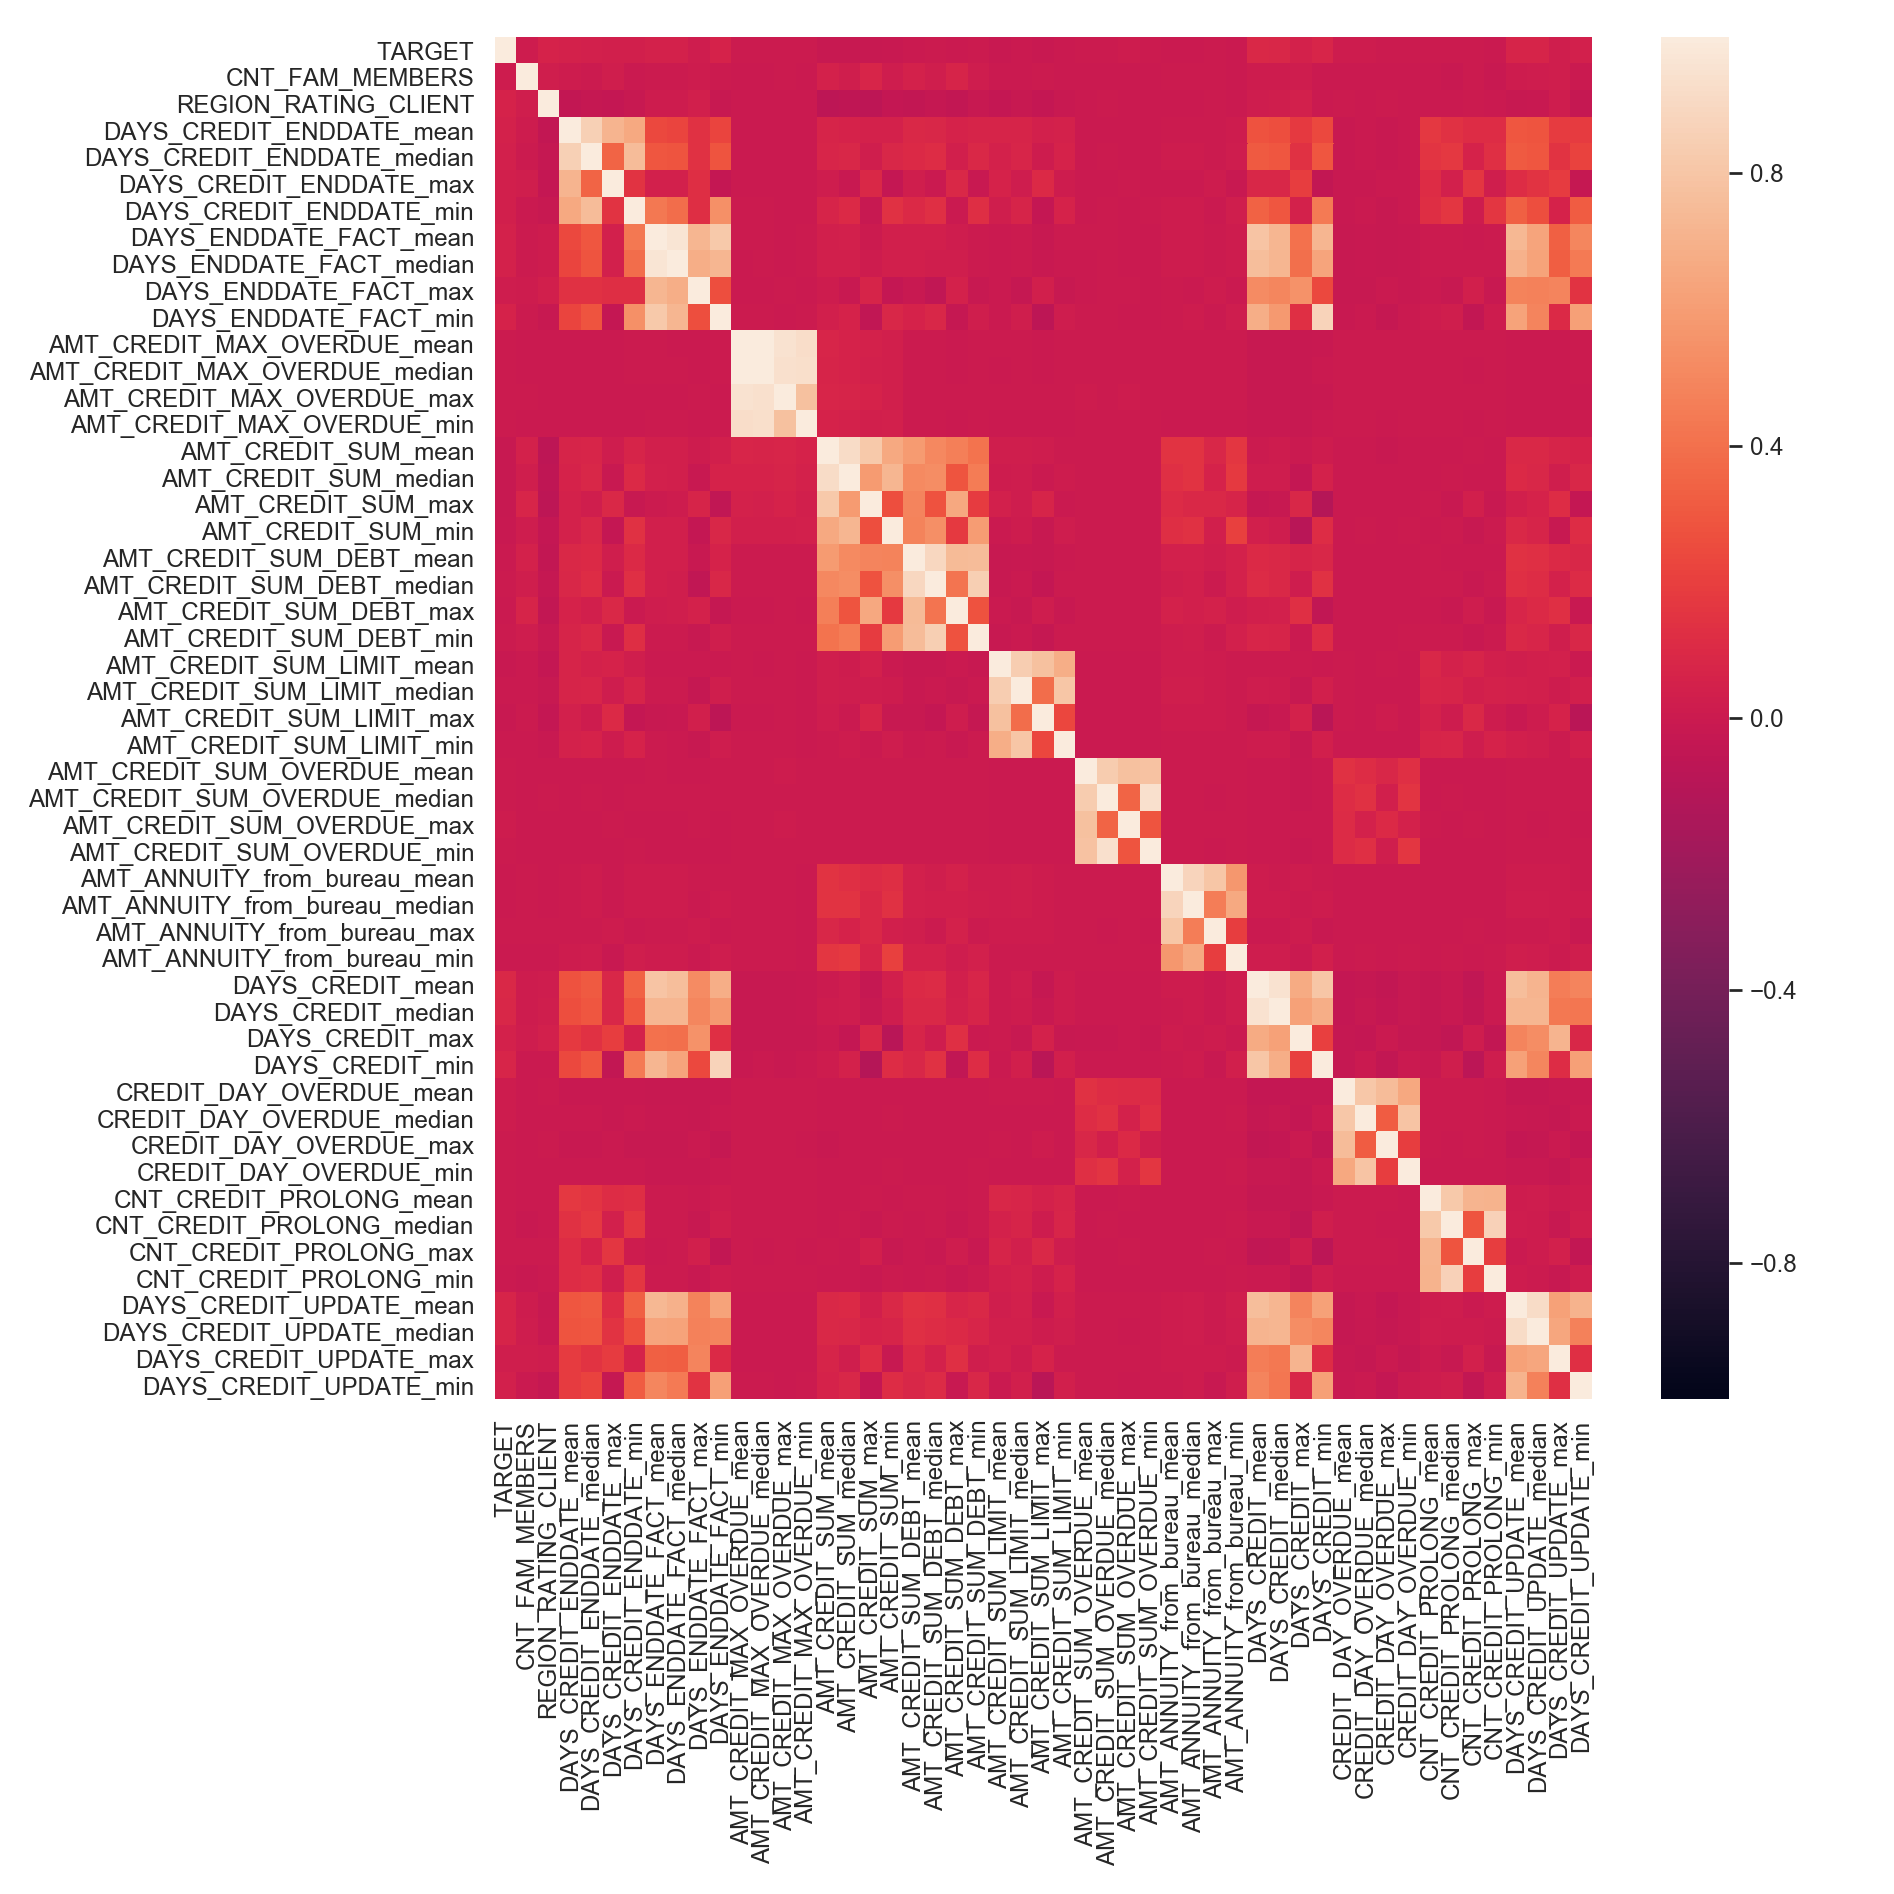

In [20]:
plt.figure(figsize= (12,12))
sns.heatmap(bureau_aggregated_final_df_wTargets_df.corr(), xticklabels= True, yticklabels= True, vmax=1, vmin = -1) #vmax=1, vmin = -1,
plt.tight_layout()

## NaN counts  - no information

In [21]:
def null_value_counts(df_in, feature):
    """Returns the fraction of TARGET = 0 and 1 for a given feature."""
    nan_counts = df_in[df_in[feature].isnull()]['TARGET'].value_counts()
    if nan_counts.size == 0:
        return None
    
    try: 
        val_0 = nan_counts.loc[0]
    except KeyError:
        val_0 = 0
    
    try:
        val_1 = nan_counts.loc[1]
    except KeyError:
        val_1 = 0
    
    tot = val_0 + val_1
    
    return [tot, val_0/tot, val_1/tot]

In [22]:
v0 , v1 = bureau_aggregated_final_df_wTargets_df['TARGET'].value_counts()
v0/(v0+v1), v1/(v0+v1)

(0.9192709180189262, 0.08072908198107379)

In [23]:
nan_dict = {}
for f in bureau_aggregated_final_df_wTargets_df.columns:
    x = null_value_counts(bureau_aggregated_final_df_wTargets_df, f)
    if x:
        nan_dict[f] = x

In [24]:
nan_df = pd.DataFrame( nan_dict)#, cols = )
nan_df = nan_df.transpose()
nan_df.columns = ['NaN counts','% TARGET = 0','% TARGET = 1']
pd.options.display.max_rows = 200
display(nan_df)
pd.options.display.max_rows = 60

NaN counts  % TARGET = 0  % TARGET = 1
CNT_FAM_MEMBERS                        2.0      1.000000      0.000000
DAYS_CREDIT_ENDDATE_mean           46269.0      0.898571      0.101429
DAYS_CREDIT_ENDDATE_median         46269.0      0.898571      0.101429
DAYS_CREDIT_ENDDATE_max            46269.0      0.898571      0.101429
DAYS_CREDIT_ENDDATE_min            46269.0      0.898571      0.101429
DAYS_ENDDATE_FACT_mean             77155.0      0.894965      0.105035
DAYS_ENDDATE_FACT_median           77155.0      0.894965      0.105035
DAYS_ENDDATE_FACT_max              77155.0      0.894965      0.105035
DAYS_ENDDATE_FACT_min              77155.0      0.894965      0.105035
AMT_CREDIT_MAX_OVERDUE_mean       123624.0      0.915858      0.084142
AMT_CREDIT_MAX_OVERDUE_median     123624.0      0.915858      0.084142
AMT_CREDIT_MAX_OVERDUE_max        123624.0      0.915858      0.084142
AMT_CREDIT_MAX_OVERDUE_min        123624.0      0.915858      0.084142
AMT_CREDIT_SUM_mean                44021.0      0.898753      0.101247
AMT_CREDIT_SUM_median              44021.0      0.898753      0.101247
AMT_CREDIT_SUM_max                 44021.0      0.898753      0.101247
AMT_CREDIT_SUM_min                 44021.0      0.898753      0.101247
AMT_CREDIT_SUM_DEBT_mean           51380.0      0.903640      0.096360
AMT_CREDIT_SUM_DEBT_median         51380.0      0.903640      0.096360
AMT_CREDIT_SUM_DEBT_max            51380.0      0.903640      0.096360
AMT_CREDIT_SUM_DEBT_min            51380.0      0.903640      0.096360
AMT_CREDIT_SUM_LIMIT_mean          65069.0      0.905377      0.094623
AMT_CREDIT_SUM_LIMIT_median        65069.0      0.905377      0.094623
AMT_CREDIT_SUM_LIMIT_max           65069.0      0.905377      0.094623
AMT_CREDIT_SUM_LIMIT_min           65069.0      0.905377      0.094623
AMT_CREDIT_SUM_OVERDUE_mean        44020.0      0.898751      0.101249
AMT_CREDIT_SUM_OVERDUE_median      44020.0      0.898751      0.101249
AMT_CREDIT_SUM_OVERDUE_max         44020.0      0.898751      0.101249
AMT_CREDIT_SUM_OVERDUE_min         44020.0      0.898751      0.101249
AMT_ANNUITY_from_bureau_mean      227501.0      0.919895      0.080105
AMT_ANNUITY_from_bureau_median    227501.0      0.919895      0.080105
AMT_ANNUITY_from_bureau_max       227501.0      0.919895      0.080105
AMT_ANNUITY_from_bureau_min       227501.0      0.919895      0.080105
DAYS_CREDIT_mean                   44020.0      0.898751      0.101249
DAYS_CREDIT_median                 44020.0      0.898751      0.101249
DAYS_CREDIT_max                    44020.0      0.898751      0.101249
DAYS_CREDIT_min                    44020.0      0.898751      0.101249
CREDIT_DAY_OVERDUE_mean            44020.0      0.898751      0.101249
CREDIT_DAY_OVERDUE_median          44020.0      0.898751      0.101249
CREDIT_DAY_OVERDUE_max             44020.0      0.898751      0.101249
CREDIT_DAY_OVERDUE_min             44020.0      0.898751      0.101249
CNT_CREDIT_PROLONG_mean            44020.0      0.898751      0.101249
CNT_CREDIT_PROLONG_median          44020.0      0.898751      0.101249
CNT_CREDIT_PROLONG_max             44020.0      0.898751      0.101249
CNT_CREDIT_PROLONG_min             44020.0      0.898751      0.101249
DAYS_CREDIT_UPDATE_mean            44020.0      0.898751      0.101249
DAYS_CREDIT_UPDATE_median          44020.0      0.898751      0.101249
DAYS_CREDIT_UPDATE_max             44020.0      0.898751      0.101249
DAYS_CREDIT_UPDATE_min             44020.0      0.898751      0.101249

# plots

In [40]:
# get a random sample bc full sample is too much to plot
this_sample = balanced_sample(bureau_aggregated_final_df_wTargets_df, 24000, 0)

these_types = bureau_aggregated_final_df_wTargets_df.dtypes

In [41]:
list(   set(  these_types[these_types == 'object'].index ) - set(app_feats_to_import) )

['CREDIT_TYPE_mode', 'CREDIT_CURRENCY_mode', 'CREDIT_ACTIVE_mode']

## categorical plots

<IPython.core.display.Javascript object>


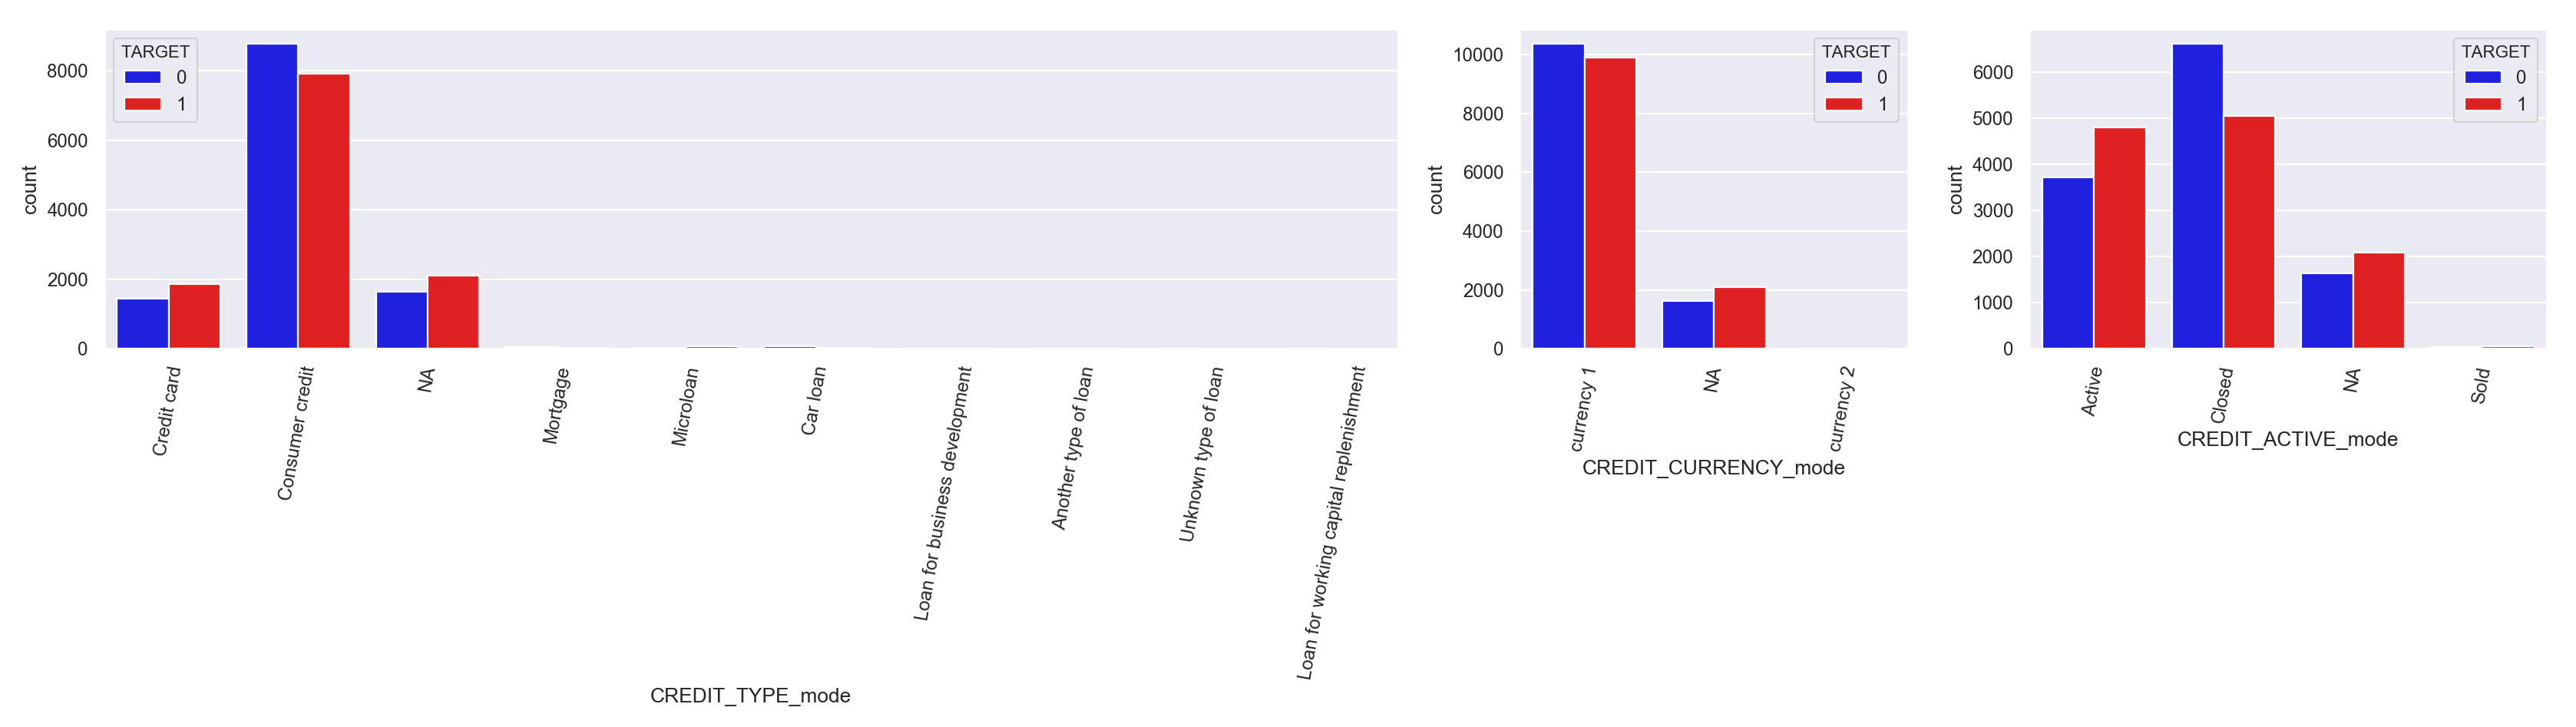

In [42]:
# PLOT CATEGORICAL FEATURES BINNED

# get categorical features
feats = list(   set(  these_types[these_types == 'object'].index ) - set(app_feats_to_import) )

# number of values for each feature for plot sizing
ratios = [len(np.unique(this_sample[f])) for f in feats]
tot_width = sum(ratios)/.8

fig, axs = plt.subplots(nrows = 1,
                        ncols = len(feats),
                        gridspec_kw = {'width_ratios':ratios},
                        figsize = (tot_width, 6));

for f, a in zip(feats, range(len(feats))):
    g = sns.countplot(x = f,
                      hue = "TARGET", 
                      data = this_sample, 
                      palette = ['blue','red'], 
                      #bw = 1,
                      ax = axs[a]
                       );
    g.set_xticklabels(g.get_xticklabels(), 
                      rotation = 80);

plt.tight_layout()

## preliminary float features (there are no int features)

In [43]:
# need to divide next set into 2 plots, so define a point to slice
slice_at = 20
these_feats = list(   set(  these_types[these_types == 'float64'].index )  )

<IPython.core.display.Javascript object>


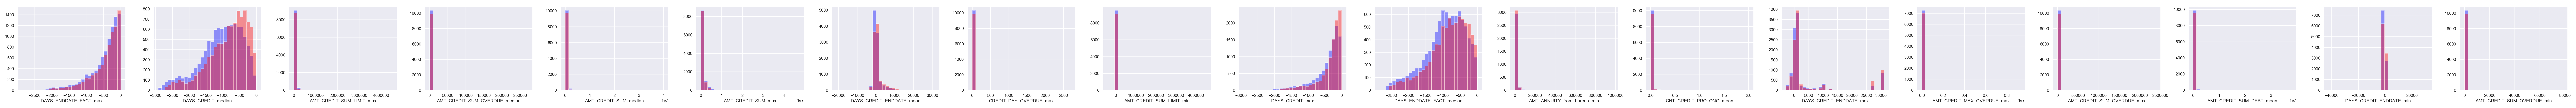

In [44]:
# PLOT FLOAT FEATURES
# get float features

my_list = list(   set(these_feats[:slice_at]) - set(app_feats_to_import) )
num_plots = len(my_list)

fig, axs = plt.subplots(nrows = 1,
                        ncols = num_plots,
                        figsize = (num_plots*5,  4));

for f, a in zip(my_list, range(len(my_list))):
    
    dat_0 = this_sample[ (this_sample['TARGET']== 0) & (this_sample[f].notna())][f]
    dat_1 = this_sample[ (this_sample['TARGET']== 1) & (this_sample[f].notna())][f]
    
    #keep data within 3 SDs of mean
    dat_0 = dat_0[~((dat_0-dat_0.mean()).abs() > 3*dat_0.std())]
    dat_1 = dat_1[~((dat_1-dat_1.mean()).abs() > 3*dat_1.std())]
    
#     #divv = 40
#     bw_0 = np.std(dat_0)/3
#     bw_1 = np.std(dat_1)/3
    
    my_bins =np.histogram(  this_sample[ (this_sample[f].notna())][f]  , bins = 30 )[1] #, 'fd'
    
    g0 = sns.distplot(dat_0, color = 'blue', ax = axs[a], kde = False, bins = my_bins)#, bw =bw_0) #( abs(max(dat_0)- min(dat_0))/divv   ) )#, bw = 90000)
    g1 = sns.distplot(dat_1, color = 'red',  ax = axs[a],kde = False, bins = my_bins)#, bw =bw_1) #( abs(max(dat_0)- min(dat_0))/divv       ) )#,   ) #, bw = 90000)
    
#     if f =='AMT_CREDIT_SUM_max':
#         #g1.set_ylim(10**4.3, 10**7)
#         g1.set_xlim(1, 10**7)
    
   # g0.set_xticklabels(g.get_xticklabels(),rotation = 80)

plt.tight_layout()

<IPython.core.display.Javascript object>


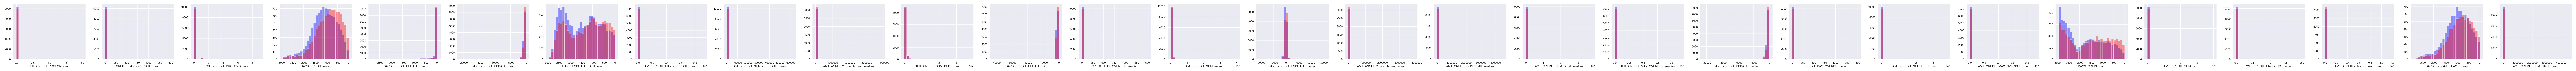

In [45]:
# PLOT SECOND HALF OF FLOAT FEATURES

my_list = list(  set(these_feats[slice_at:]) - set(app_feats_to_import))
num_plots = len(my_list)

fig, axs = plt.subplots(nrows = 1,
                        ncols = num_plots,
                        figsize = (num_plots*5,  4));

for f, a in zip(my_list, range(len(my_list))):
   
    dat_0 = this_sample[ (this_sample['TARGET']== 0) & (this_sample[f].notna())][f]
    dat_1 = this_sample[ (this_sample['TARGET']== 1) & (this_sample[f].notna())][f]
    
    #divv = 40
    
#     bw_0 = np.std(dat_0)/3
#     bw_1 = np.std(dat_1)/3
    my_bins =np.histogram(  this_sample[ (this_sample[f].notna())][f]  , bins = 30 )[1] #, 'fd'
    
    g0 = sns.distplot(dat_0, color = 'blue', ax = axs[a], kde = False, bins = my_bins)#, bw = bw_0) #( abs(max(dat_0)- min(dat_0))/divv   ) )#, bw = 90000)
    g1 = sns.distplot(dat_1, color = 'red',  ax = axs[a], kde = False, bins = my_bins)#, bw = bw_1) #( abs(max(dat_0)- min(dat_0))/divv       ) )#,   ) #, bw = 90000)
    
   # g0.set_xticklabels(g.get_xticklabels(),rotation = 80)

plt.tight_layout()

## feats = 0, >0, <0, NA cat plots. I don't see any novel info

In [46]:
types = bureau_aggregated_final_df_wTargets_df.dtypes
float_feats = list(  set(types[types =='float'].index) - set(app_feats_to_import) )

In [47]:
def float_categories(x):
    if x>0:
        return '>0'
    if x==0:
        return '0'
    if x<0:
        return '<0'
    else:
        return 'NA'

In [48]:
float_categories_sample_df = this_sample[float_feats].applymap(float_categories)

### basic version

In [49]:
float_categories_sample_df_wTargets_df = pd.merge(app_train_short[['TARGET']], float_categories_sample_df, on  = 'SK_ID_CURR', how = 'right')aa

SyntaxError: invalid syntax (<ipython-input-49-b6ab07e2dca6>, line 1)

In [ ]:
slice_at = 24

In [ ]:
# PLOT FLOAT CATEGORICAL FEATURES BINNED

# get categorical features
feats = float_feats[:slice_at]
this_df = float_categories_sample_df_wTargets_df

# number of values for each feature for plot sizing
ratios = [len(np.unique(this_df[f])) for f in feats]
tot_width = sum(ratios)/.8

fig, axs = plt.subplots(nrows = 1,
                        ncols = len(feats),
                        gridspec_kw = {'width_ratios':ratios},
                        figsize = (tot_width, 6));

for f, a in zip(feats, range(len(feats))):
    g = sns.countplot(x = f,
                      hue = "TARGET", 
                      data = this_df, 
                      palette = ['blue','red'], 
                      #bw = 1,
                      ax = axs[a]
                       );
    g.set_xticklabels(g.get_xticklabels(), 
                      rotation = 80);

plt.tight_layout()

In [ ]:
# PLOT FLOAT CATEGORICAL FEATURES BINNED

# get categorical features
feats = float_feats[slice_at:]
this_df = float_categories_sample_df_wTargets_df

# number of values for each feature for plot sizing
ratios = [len(np.unique(this_df[f])) for f in feats]
tot_width = sum(ratios)/.8

fig, axs = plt.subplots(nrows = 1,
                        ncols = len(feats),
                        gridspec_kw = {'width_ratios':ratios},
                        figsize = (tot_width, 6));

for f, a in zip(feats, range(len(feats))):
    g = sns.countplot(x = f,
                      hue = "TARGET", 
                      data = this_df, 
                      palette = ['blue','red'], 
                      #bw = 1,
                      ax = axs[a]
                       );
    g.set_xticklabels(g.get_xticklabels(), 
                      rotation = 80);

plt.tight_layout()

### also splitting on M/F car - I don't think this has much info in it, or at least significantly more than just spliting on Gender//car usually 

In [ ]:
float_categories_sample_df_wTargets_df = pd.merge(app_train_short[['TARGET','CODE_GENDER','FLAG_OWN_CAR' ]], float_categories_sample_df, on  = 'SK_ID_CURR', how = 'right')

In [ ]:
slice_at = 2

In [ ]:
float_categories_sample_df_wTargets_df[float_feats[0]]

In [ ]:
g = sns.catplot(data = float_categories_sample_df_wTargets_df, 
                x = float_feats[2],
                kind = 'count',
                row = 'FLAG_OWN_CAR',
                col = 'CODE_GENDER',
                hue = "TARGET", 
                palette = ['blue','red'], 
                height = 3,
                       );
#g.set_xticklabels(g.get_xticklabels(), rotation = 80);

plt.tight_layout()

In [ ]:
g = sns.catplot(data = float_categories_sample_df_wTargets_df, 
                x = float_feats[10],
                kind = 'count',
                row = 'FLAG_OWN_CAR',
                col = 'CODE_GENDER',
                hue = "TARGET", 
                palette = ['blue','red'], 
                height = 3,
                       );
#g.set_xticklabels(g.get_xticklabels(), rotation = 80);

plt.tight_layout()

In [ ]:
g = sns.catplot(data = float_categories_sample_df_wTargets_df, 
                x = 'DAYS_CREDIT_ENDDATE_mean',
                kind = 'count',
                row = 'FLAG_OWN_CAR',
                col = 'CODE_GENDER',
                hue = "TARGET", 
                palette = ['blue','red'], 
                height = 3,
                       );
#g.set_xticklabels(g.get_xticklabels(), rotation = 80);

plt.tight_layout()

In [ ]:
g = sns.catplot(data = float_categories_sample_df_wTargets_df, 
                x = 'DAYS_CREDIT_ENDDATE_max',
                kind = 'count',
                row = 'FLAG_OWN_CAR',
                col = 'CODE_GENDER',
                hue = "TARGET", 
                palette = ['blue','red'], 
                height = 3,
                       );
#g.set_xticklabels(g.get_xticklabels(), rotation = 80);

plt.tight_layout()

In [ ]:
g = sns.catplot(data = float_categories_sample_df_wTargets_df, 
                x = 'DAYS_ENDDATE_FACT_min',
                kind = 'count',
                row = 'FLAG_OWN_CAR',
                col = 'CODE_GENDER',
                hue = "TARGET", 
                palette = ['blue','red'], 
                height = 3,
                       );
#g.set_xticklabels(g.get_xticklabels(), rotation = 80);

plt.tight_layout()

## plot float feats without feat=0 vals - this doesn't help so much bc of many orders of magnitude in many feats

In [ ]:
# PLOT FLOAT FEATURES FIRST HALF
# get float features

my_list = list(   set(these_feats[:slice_at]) - set(app_feats_to_import) )
num_plots = len(my_list)

fig, axs = plt.subplots(nrows = 1,
                        ncols = num_plots,
                        figsize = (num_plots*5,  4));

for f, a in zip(my_list, range(len(my_list))):

    
    dat_0 = this_sample[ (this_sample['TARGET']== 0) & (this_sample[f].notna()) &(this_sample[f]!=0)  ][f]
    dat_1 = this_sample[ (this_sample['TARGET']== 1) & (this_sample[f].notna())&(this_sample[f]!=0) ][f]
    
    #keep data within 3 SDs of mean
    dat_0 = dat_0[~((dat_0-dat_0.mean()).abs() > 3*dat_0.std())]
    dat_1 = dat_1[~((dat_1-dat_1.mean()).abs() > 3*dat_1.std())]
    
    
    my_bins =np.histogram(  this_sample[ (this_sample[f].notna())][f]  , bins = 30 )[1] #, 'fd'
#     #divv = 40
#     bw_0 = np.std(dat_0)/3
#     bw_1 = np.std(dat_1)/3
    
    g0 = sns.distplot(dat_0, color = 'blue', ax = axs[a], kde = False, bins = my_bins)#, bw =bw_0) #( abs(max(dat_0)- min(dat_0))/divv   ) )#, bw = 90000)
    g1 = sns.distplot(dat_1, color = 'red',  ax = axs[a],kde = False, bins = my_bins)#, bw =bw_1) #( abs(max(dat_0)- min(dat_0))/divv       ) )#,   ) #, bw = 90000)
    
    
   # g0.set_xticklabels(g.get_xticklabels(),rotation = 80)

plt.tight_layout()

In [ ]:
# PLOT FLOAT FEATURES SECOND HALF
# get float features

my_list = list(   set(these_feats[:slice_at]) - set(app_feats_to_import) )
num_plots = len(my_list)

fig, axs = plt.subplots(nrows = 1,
                        ncols = num_plots,
                        figsize = (num_plots*5,  4));

for f, a in zip(my_list, range(len(my_list))):

    
    dat_0 = this_sample[ (this_sample['TARGET']== 0) & (this_sample[f].notna()) &(this_sample[f]!=0)  ][f]
    dat_1 = this_sample[ (this_sample['TARGET']== 1) & (this_sample[f].notna())&(this_sample[f]!=0) ][f]
    
    #keep data within 3 SDs of mean
    dat_0 = dat_0[~((dat_0-dat_0.mean()).abs() > 3*dat_0.std())]
    dat_1 = dat_1[~((dat_1-dat_1.mean()).abs() > 3*dat_1.std())]
    
    my_bins =np.histogram(  this_sample[ (this_sample[f].notna())][f]  , bins = 30 )[1] #, 'fd'
#     #divv = 40
#     bw_0 = np.std(dat_0)/3
#     bw_1 = np.std(dat_1)/3
    
    g0 = sns.distplot(dat_0, color = 'blue', ax = axs[a], kde = False, bins = my_bins)#, bw =bw_0) #( abs(max(dat_0)- min(dat_0))/divv   ) )#, bw = 90000)
    g1 = sns.distplot(dat_1, color = 'red',  ax = axs[a],kde = False, bins = my_bins)#, bw =bw_1) #( abs(max(dat_0)- min(dat_0))/divv       ) )#,   ) #, bw = 90000)
    
    
   # g0.set_xticklabels(g.get_xticklabels(),rotation = 80)

plt.tight_layout()

## Log Mod features

In [ ]:
def log_modulus_transformation(x):
    return np.sign(x)*np.log10( np.abs(x)+1)

In [ ]:
this_sample['LogMod_AMT_ANNUITY_from_bureau_mean'] = log_modulus_transformation(this_sample['AMT_ANNUITY_from_bureau_mean'])
this_sample['LogMod_AMT_ANNUITY_from_bureau_median'] = log_modulus_transformation(this_sample['AMT_ANNUITY_from_bureau_median'])
this_sample['LogMod_AMT_ANNUITY_from_bureau_min'] = log_modulus_transformation(this_sample['AMT_ANNUITY_from_bureau_min'])
this_sample['LogMod_AMT_ANNUITY_from_bureau_max'] = log_modulus_transformation(this_sample['AMT_ANNUITY_from_bureau_max'])

this_sample['LogMod_AMT_CREDIT_SUM_mean'] = log_modulus_transformation(this_sample['AMT_CREDIT_SUM_mean'])
this_sample['LogMod_AMT_CREDIT_SUM_median'] = log_modulus_transformation(this_sample['AMT_CREDIT_SUM_median'])
this_sample['LogMod_AMT_CREDIT_SUM_max'] = log_modulus_transformation(this_sample['AMT_CREDIT_SUM_max'])
this_sample['LogMod_AMT_CREDIT_SUM_min'] = log_modulus_transformation(this_sample['AMT_CREDIT_SUM_min'])

this_sample['LogMod_AMT_CREDIT_SUM_DEBT_mean'] = log_modulus_transformation(this_sample['AMT_CREDIT_SUM_DEBT_mean'])
this_sample['LogMod_AMT_CREDIT_SUM_DEBT_median'] = log_modulus_transformation(this_sample['AMT_CREDIT_SUM_DEBT_median'])
this_sample['LogMod_AMT_CREDIT_SUM_DEBT_max'] = log_modulus_transformation(this_sample['AMT_CREDIT_SUM_DEBT_max'])

this_sample['LogMod_AMT_CREDIT_SUM_LIMIT_mean'] = log_modulus_transformation(this_sample['AMT_CREDIT_SUM_LIMIT_mean'])
this_sample['LogMod_AMT_CREDIT_SUM_LIMIT_max'] = log_modulus_transformation(this_sample['AMT_CREDIT_SUM_LIMIT_max'])
this_sample['LogMod_AMT_CREDIT_SUM_LIMIT_min'] = log_modulus_transformation(this_sample['AMT_CREDIT_SUM_LIMIT_min'])

this_sample['LogMod_AMT_CREDIT_SUM_OVERDUE_mean'] = log_modulus_transformation(this_sample['AMT_CREDIT_SUM_OVERDUE_mean'])
this_sample['LogMod_AMT_CREDIT_SUM_OVERDUE_max'] = log_modulus_transformation(this_sample['AMT_CREDIT_SUM_OVERDUE_max'])
this_sample['LogMod_AMT_CREDIT_SUM_OVERDUE_min'] = log_modulus_transformation(this_sample['AMT_CREDIT_SUM_OVERDUE_min'])

this_sample['LogMod_AMT_CREDIT_MAX_OVERDUE_mean'] = log_modulus_transformation(this_sample['AMT_CREDIT_MAX_OVERDUE_mean'])
this_sample['LogMod_AMT_CREDIT_MAX_OVERDUE_min'] = log_modulus_transformation(this_sample['AMT_CREDIT_MAX_OVERDUE_min'])
this_sample['LogMod_AMT_CREDIT_MAX_OVERDUE_max'] = log_modulus_transformation(this_sample['AMT_CREDIT_MAX_OVERDUE_max'])
this_sample['LogMod_AMT_CREDIT_MAX_OVERDUE_median'] = log_modulus_transformation(this_sample['AMT_CREDIT_MAX_OVERDUE_median'])

this_sample['LogMod_AMT_CREDIT_SUM_DEBT_min'] = log_modulus_transformation(this_sample['AMT_CREDIT_SUM_DEBT_min'])

this_sample['LogMod_CNT_CREDIT_PROLONG_mean'] = log_modulus_transformation(this_sample['CNT_CREDIT_PROLONG_mean'])
this_sample['LogMod_CNT_CREDIT_PROLONG_median'] = log_modulus_transformation(this_sample['CNT_CREDIT_PROLONG_median'])
this_sample['LogMod_CNT_CREDIT_PROLONG_min'] = log_modulus_transformation(this_sample['CNT_CREDIT_PROLONG_min'])
this_sample['LogMod_CNT_CREDIT_PROLONG_max'] = log_modulus_transformation(this_sample['CNT_CREDIT_PROLONG_max'])

this_sample['LogMod_CREDIT_DAY_OVERDUE_mean'] = log_modulus_transformation(this_sample['CREDIT_DAY_OVERDUE_mean'])
this_sample['LogMod_CREDIT_DAY_OVERDUE_max'] = log_modulus_transformation(this_sample['CREDIT_DAY_OVERDUE_max'])
this_sample['LogMod_CREDIT_DAY_OVERDUE_min'] = log_modulus_transformation(this_sample['CREDIT_DAY_OVERDUE_min'])

this_sample['LogMod_DAYS_CREDIT_ENDDATE_mean'] = log_modulus_transformation(this_sample['DAYS_CREDIT_ENDDATE_mean'])
this_sample['LogMod_DAYS_CREDIT_ENDDATE_max'] = log_modulus_transformation(this_sample['DAYS_CREDIT_ENDDATE_max'])
this_sample['LogMod_DAYS_CREDIT_ENDDATE_median'] = log_modulus_transformation(this_sample['DAYS_CREDIT_ENDDATE_median'])

this_sample['LogMod_DAYS_CREDIT_UPDATE_max'] = log_modulus_transformation(this_sample['DAYS_CREDIT_UPDATE_max'])
this_sample['LogMod_DAYS_CREDIT_UPDATE_mean'] = log_modulus_transformation(this_sample['DAYS_CREDIT_UPDATE_mean'])

this_sample['LogMod_DAYS_ENDDATE_FACT_max'] = log_modulus_transformation(this_sample['DAYS_ENDDATE_FACT_max'])

LogMod_list = [
'LogMod_AMT_ANNUITY_from_bureau_mean',
'LogMod_AMT_ANNUITY_from_bureau_median',
'LogMod_AMT_ANNUITY_from_bureau_min',
'LogMod_AMT_ANNUITY_from_bureau_max',
'LogMod_AMT_CREDIT_SUM_mean',
'LogMod_AMT_CREDIT_SUM_median',
'LogMod_AMT_CREDIT_SUM_max',
'LogMod_AMT_CREDIT_SUM_min',
'LogMod_AMT_CREDIT_SUM_DEBT_mean',
'LogMod_AMT_CREDIT_SUM_DEBT_median',
'LogMod_AMT_CREDIT_SUM_DEBT_max',
'LogMod_AMT_CREDIT_SUM_LIMIT_mean',
'LogMod_AMT_CREDIT_SUM_LIMIT_max',
'LogMod_AMT_CREDIT_SUM_LIMIT_min',
'LogMod_AMT_CREDIT_SUM_OVERDUE_mean',
'LogMod_AMT_CREDIT_SUM_OVERDUE_max',
'LogMod_AMT_CREDIT_SUM_OVERDUE_min',
'LogMod_AMT_CREDIT_MAX_OVERDUE_mean',
'LogMod_AMT_CREDIT_MAX_OVERDUE_min',
'LogMod_AMT_CREDIT_MAX_OVERDUE_max',
'LogMod_AMT_CREDIT_MAX_OVERDUE_median',
'LogMod_AMT_CREDIT_SUM_DEBT_min',
'LogMod_CNT_CREDIT_PROLONG_mean',
'LogMod_CNT_CREDIT_PROLONG_median',
'LogMod_CNT_CREDIT_PROLONG_min',
'LogMod_CNT_CREDIT_PROLONG_max',
'LogMod_CREDIT_DAY_OVERDUE_mean',
'LogMod_CREDIT_DAY_OVERDUE_max',
'LogMod_CREDIT_DAY_OVERDUE_min',
'LogMod_DAYS_CREDIT_ENDDATE_mean',
'LogMod_DAYS_CREDIT_ENDDATE_max',
'LogMod_DAYS_CREDIT_ENDDATE_median',
'LogMod_DAYS_CREDIT_UPDATE_max',
'LogMod_DAYS_CREDIT_UPDATE_mean',
'LogMod_DAYS_ENDDATE_FACT_max',
]

In [ ]:
len(LogMod_list)

### plots

In [ ]:
my_list = LogMod_list
num_plots = len(my_list)

fig, axs = plt.subplots(nrows = 1,
                        ncols = num_plots,
                        figsize = (num_plots*5,  4));

for f, a in zip(my_list, range(len(my_list))):  
    dat_0 = this_sample[ (this_sample['TARGET']== 0) & (this_sample[f].notna())][f]
    dat_1 = this_sample[ (this_sample['TARGET']== 1) & (this_sample[f].notna())][f]
    
    #divv = 40
    
#     bw_0 = np.std(dat_0)/3
#     bw_1 = np.std(dat_1)/3
    
    my_bins =np.histogram(  this_sample[ (this_sample[f].notna())][f]  , bins = 30 )[1] #, 'fd'
    
    g0 = sns.distplot(dat_0, color = 'blue', ax = axs[a], kde = False, bins = my_bins)#, bw = bw_0) #( abs(max(dat_0)- min(dat_0))/divv   ) )#, bw = 90000)
    g1 = sns.distplot(dat_1, color = 'red',  ax = axs[a], kde = False, bins = my_bins)#, bw = bw_1) #( abs(max(dat_0)- min(dat_0))/divv       ) )#,   ) #, bw = 90000)
    
   # g0.set_xticklabels(g.get_xticklabels(),rotation = 80)

plt.tight_layout()

### plots without zeros, some of these are small portions and are a bit dangerous to draw conclusions from. 

In [ ]:
# PLOT LOGMODs feats!= 0 

my_list = LogMod_list
num_plots = len(my_list)

fig, axs = plt.subplots(nrows = 1,
                        ncols = num_plots,
                        figsize = (num_plots*5,  4));

for f, a in zip(my_list, range(len(my_list))):
   
    dat_0 = this_sample[ (this_sample['TARGET']== 0) & (this_sample[f].notna()) & (this_sample[f]!=0) ][f]
    dat_1 = this_sample[ (this_sample['TARGET']== 1) & (this_sample[f].notna()) & (this_sample[f]!=0)  ][f]
    
    #divv = 40
    
#     bw_0 = np.std(dat_0)/3
#     bw_1 = np.std(dat_1)/3
    
    my_bins =np.histogram(  this_sample[ (this_sample[f].notna()) & (this_sample[f]!=0) ][f]  , bins = 30 )[1] #, 'fd'
    
    g0 = sns.distplot(dat_0, color = 'blue', ax = axs[a], kde = False, bins = my_bins)#, bw = bw_0) #( abs(max(dat_0)- min(dat_0))/divv   ) )#, bw = 90000)
    g1 = sns.distplot(dat_1, color = 'red',  ax = axs[a], kde = False, bins = my_bins)#, bw = bw_1) #( abs(max(dat_0)- min(dat_0))/divv       ) )#,   ) #, bw = 90000)
    
   # g0.set_xticklabels(g.get_xticklabels(),rotation = 80)

plt.tight_layout()

## new(mostly log transformation) and important float features

In [ ]:
#bureau_aggregated_final_df_wTargets_df['NegLog_DAYS_CREDIT_mean'] = np.log10(- bureau_aggregated_final_df_wTargets_df['DAYS_CREDIT_mean'] +1)
bureau_aggregated_final_df_wTargets_df['Log_AMT_CREDIT_SUM_max'] = np.log10(+bureau_aggregated_final_df_wTargets_df['AMT_CREDIT_SUM_max'] +1)
bureau_aggregated_final_df_wTargets_df['Log_AMT_CREDIT_SUM_mean'] = np.log10(+bureau_aggregated_final_df_wTargets_df['AMT_CREDIT_SUM_mean'] +1)
bureau_aggregated_final_df_wTargets_df['Log_AMT_CREDIT_MAX_OVERDUE_mean'] = np.log10(+bureau_aggregated_final_df_wTargets_df['AMT_CREDIT_MAX_OVERDUE_mean'] +1)
bureau_aggregated_final_df_wTargets_df['Log_AMT_ANNUITY_from_bureau_max'] = np.log10(+bureau_aggregated_final_df_wTargets_df['AMT_ANNUITY_from_bureau_max'] +1)
bureau_aggregated_final_df_wTargets_df['NegLog_DAYS_CREDIT_UPDATE_mean'] = np.log10(-bureau_aggregated_final_df_wTargets_df['DAYS_CREDIT_UPDATE_mean'] +1)
bureau_aggregated_final_df_wTargets_df['NegLog_DAYS_ENDDATE_FACT_mean'] = np.log10(-bureau_aggregated_final_df_wTargets_df['DAYS_ENDDATE_FACT_mean'] +1)
bureau_aggregated_final_df_wTargets_df['NegLog_DAYS_CREDIT_max'] = np.log10(-bureau_aggregated_final_df_wTargets_df['DAYS_CREDIT_max'] +1)
bureau_aggregated_final_df_wTargets_df['NegLog_DAYS_CREDIT_min'] = np.log10(-bureau_aggregated_final_df_wTargets_df['DAYS_CREDIT_min'] +1)
bureau_aggregated_final_df_wTargets_df['NegLog_DAYS_ENDDATE_FACT_max'] = np.log10(-bureau_aggregated_final_df_wTargets_df['DAYS_ENDDATE_FACT_max'] +1)

In [ ]:
master_float_feats = ['DAYS_CREDIT_mean',
                      'Log_AMT_CREDIT_SUM_max',
                      'Log_AMT_CREDIT_SUM_mean',
                      'DAYS_CREDIT_ENDDATE_min',
                      'AMT_CREDIT_SUM_DEBT_mean',
                      'Log_AMT_CREDIT_MAX_OVERDUE_mean',
                      'Log_AMT_ANNUITY_from_bureau_max',
                      'NegLog_DAYS_CREDIT_UPDATE_mean',
                      'NegLog_DAYS_ENDDATE_FACT_mean',
                      'NegLog_DAYS_CREDIT_max',
                      'NegLog_DAYS_CREDIT_min',
                      'NegLog_DAYS_ENDDATE_FACT_max',
                         ]

In [ ]:
# get a random sample bc full sample is too much to plot
this_sample = balanced_sample(bureau_aggregated_final_df_wTargets_df, 24000, 0)

In [ ]:
# PLOT LOG FLOAT FEATURES
my_list = master_float_feats
num_plots = len(my_list)

fig, axs = plt.subplots(nrows = 1,
                        ncols = num_plots,
                        figsize = (num_plots*5,  4));

for f, a in zip(my_list, range(len(my_list))):
   
    dat_0 = this_sample[ (this_sample['TARGET']== 0) & (this_sample[f].notna())][f]
    dat_1 = this_sample[ (this_sample['TARGET']== 1) & (this_sample[f].notna())][f]
    
    #divv = 40

    dat_0 = dat_0[~((dat_0-dat_0.mean()).abs() > 3*dat_0.std())]
    dat_1 = dat_1[~((dat_1-dat_1.mean()).abs() > 3*dat_1.std())]
    
#     dat = this_sample[ (this_sample[f].notna())][f]
#     bins = 
    
#     bw_0 = np.std(dat_0)/3
#     bw_1 = np.std(dat_1)/3
    
    g0 = sns.distplot(dat_0, color = 'blue', ax = axs[a], kde = False)#, bw = bw_0) #( abs(max(dat_0)- min(dat_0))/divv   ) )#, bw = 90000)
    g1 = sns.distplot(dat_1, color = 'red',  ax = axs[a], kde = False)#, bw = bw_1) #( abs(max(dat_0)- min(dat_0))/divv       ) )#,   ) #, bw = 90000)
    
   # g0.set_xticklabels(g.get_xticklabels(),rotation = 80)

plt.tight_layout()

In [ ]:
my_list = ['Log_AMT_ANNUITY_from_bureau_max']
num_plots = len(my_list)

fig, axs = plt.subplots(nrows = 1,
                        ncols = 1,
                        figsize = (6,  6));
   
dat_0 = this_sample[ (this_sample['TARGET']== 0) & (this_sample[f].notna())][f]
dat_1 = this_sample[ (this_sample['TARGET']== 1) & (this_sample[f].notna())][f]
    
    #divv = 40
dat_0 = dat_0[~((dat_0-dat_0.mean()).abs() > 3*dat_0.std())]
dat_1 = dat_1[~((dat_1-dat_1.mean()).abs() > 3*dat_1.std())]
    
#     dat = this_sample[ (this_sample[f].notna())][f]
#     bins = 
    
#     bw_0 = np.std(dat_0)/3
#     bw_1 = np.std(dat_1)/3
    
g0 = sns.distplot(dat_0, color = 'blue', ax = axs, kde = False)#, bw = bw_0) #( abs(max(dat_0)- min(dat_0))/divv   ) )#, bw = 90000)
g1 = sns.distplot(dat_1, color = 'red',  ax = axs, kde = False)#, bw = bw_1) #( abs(max(dat_0)- min(dat_0))/divv       ) )#,   ) #, bw = 90000)
    
   # g0.set_xticklabels(g.get_xticklabels(),rotation = 80)

plt.tight_layout()

## plot final best features to investigate

### first stab

In [ ]:
best_feats_1 = ['DAYS_CREDIT_min',
                'DAYS_CREDIT_mean',
                'DAYS_ENDDATE_FACT_min',]

best_feats_2 = ['DAYS_CREDIT_median',
                'DAYS_ENDDATE_FACT_median',
                'LogMod_AMT_ANNUITY_from_bureau_mean',]

best_feats_3 = ['LogMod_AMT_CREDIT_SUM_DEBT_mean',
                'LogMod_DAYS_CREDIT_ENDDATE_mean', 
                'LogMod_DAYS_CREDIT_UPDATE_mean']

In [ ]:
my_list = best_feats_1
num_plots = len(my_list)

fig, axs = plt.subplots(nrows = 1,
                        ncols = num_plots,
                        figsize = (num_plots*5,  4));

for f, a in zip(my_list, range(len(my_list))):
   
    dat_0 = this_sample[ (this_sample['TARGET']== 0) & (this_sample[f].notna())][f]
    dat_1 = this_sample[ (this_sample['TARGET']== 1) & (this_sample[f].notna())][f]
    
    #divv = 40
    
#     bw_0 = np.std(dat_0)/3
#     bw_1 = np.std(dat_1)/3
    
    my_bins =np.histogram(  this_sample[ (this_sample[f].notna())][f]  , bins = 30 )[1] #, 'fd'
    
    g0 = sns.distplot(dat_0, color = 'blue', ax = axs[a], kde = False, bins = my_bins)#, bw = bw_0) #( abs(max(dat_0)- min(dat_0))/divv   ) )#, bw = 90000)
    g1 = sns.distplot(dat_1, color = 'red',  ax = axs[a], kde = False, bins = my_bins)#, bw = bw_1) #( abs(max(dat_0)- min(dat_0))/divv       ) )#,   ) #, bw = 90000)
    
   # g0.set_xticklabels(g.get_xticklabels(),rotation = 80)

plt.tight_layout()

In [ ]:
my_list = best_feats_2
num_plots = len(my_list)

fig, axs = plt.subplots(nrows = 1,
                        ncols = num_plots,
                        figsize = (num_plots*4,  4));

for f, a in zip(my_list, range(len(my_list))):
   
    dat_0 = this_sample[ (this_sample['TARGET']== 0) & (this_sample[f].notna())][f]
    dat_1 = this_sample[ (this_sample['TARGET']== 1) & (this_sample[f].notna())][f]
    
    #divv = 40
    
#     bw_0 = np.std(dat_0)/3
#     bw_1 = np.std(dat_1)/3
    
    my_bins =np.histogram(  this_sample[ (this_sample[f].notna())][f]  , bins = 30 )[1] #, 'fd'
    
    g0 = sns.distplot(dat_0, color = 'blue', ax = axs[a], kde = False, bins = my_bins)#, bw = bw_0) #( abs(max(dat_0)- min(dat_0))/divv   ) )#, bw = 90000)
    g1 = sns.distplot(dat_1, color = 'red',  ax = axs[a], kde = False, bins = my_bins)#, bw = bw_1) #( abs(max(dat_0)- min(dat_0))/divv       ) )#,   ) #, bw = 90000)
    
   # g0.set_xticklabels(g.get_xticklabels(),rotation = 80)

plt.tight_layout()

In [ ]:
my_list = best_feats_3
num_plots = len(my_list)

fig, axs = plt.subplots(nrows = 1,
                        ncols = num_plots,
                        figsize = (num_plots*4,  4));

for f, a in zip(my_list, range(len(my_list))):
   
    dat_0 = this_sample[ (this_sample['TARGET']== 0) & (this_sample[f].notna())][f]
    dat_1 = this_sample[ (this_sample['TARGET']== 1) & (this_sample[f].notna())][f]
    
    #divv = 40
    
#     bw_0 = np.std(dat_0)/3
#     bw_1 = np.std(dat_1)/3
    
    my_bins =np.histogram(  this_sample[ (this_sample[f].notna())][f]  , bins = 30 )[1] #, 'fd'
    
    g0 = sns.distplot(dat_0, color = 'blue', ax = axs[a], kde = False, bins = my_bins)#, bw = bw_0) #( abs(max(dat_0)- min(dat_0))/divv   ) )#, bw = 90000)
    g1 = sns.distplot(dat_1, color = 'red',  ax = axs[a], kde = False, bins = my_bins)#, bw = bw_1) #( abs(max(dat_0)- min(dat_0))/divv       ) )#,   ) #, bw = 90000)
    
   # g0.set_xticklabels(g.get_xticklabels(),rotation = 80)

plt.tight_layout()

### better second stab - some of these should probably be binned, not contiunous. 

In [ ]:
def log_modulus_transformation(x):
    return np.sign(x)*np.log10( np.abs(x)+1)

def pwr_transformation(x,pwr):
    return np.sign(x)*( np.abs(x) )**pwr

In [ ]:
best_feats = [  'DAYS_CREDIT_min',
                'DAYS_CREDIT_mean',
                'DAYS_ENDDATE_FACT_min',
                'DAYS_CREDIT_median',
                'DAYS_ENDDATE_FACT_median',
                'AMT_ANNUITY_from_bureau_mean',
                'AMT_CREDIT_SUM_DEBT_mean',
                'DAYS_CREDIT_ENDDATE_mean', 
                'DAYS_CREDIT_UPDATE_mean',
               ]

In [ ]:
feat = 'DAYS_CREDIT_min'
this_sample['LogMod_'+ feat] = log_modulus_transformation(this_sample[feat])
this_sample['pwr_'+ feat] = (-this_sample[feat])**(1/3)

my_list = [feat, 'LogMod_'+feat, 'pwr_'+ feat]
num_plots = len(my_list)

fig, axs = plt.subplots(nrows = 1,
                        ncols = num_plots,
                        figsize = (num_plots*5,  4));

for f, a in zip(my_list, range(len(my_list))):   
    dat_0 = this_sample[ (this_sample['TARGET']== 0) & (this_sample[f].notna())][f]
    dat_1 = this_sample[ (this_sample['TARGET']== 1) & (this_sample[f].notna())][f]

    my_bins =np.histogram(  this_sample[ (this_sample[f].notna())][f]  , bins = 30 )[1] 
    
    g0 = sns.distplot(dat_0, color = 'blue', ax = axs[a], kde = False, bins = my_bins)
    g1 = sns.distplot(dat_1, color = 'red',  ax = axs[a], kde = False, bins = my_bins)
    
plt.tight_layout()

In [ ]:
feat = 'DAYS_CREDIT_mean'
this_sample['LogMod_'+ feat] = log_modulus_transformation(this_sample[feat])
this_sample['pwr_'+ feat] = (-this_sample[feat])**(1/1.7)

my_list = [feat, 'LogMod_'+feat, 'pwr_'+ feat]
num_plots = len(my_list)

fig, axs = plt.subplots(nrows = 1,
                        ncols = num_plots,
                        figsize = (num_plots*5,  4));

for f, a in zip(my_list, range(len(my_list))):   
    dat_0 = this_sample[ (this_sample['TARGET']== 0) & (this_sample[f].notna())][f]
    dat_1 = this_sample[ (this_sample['TARGET']== 1) & (this_sample[f].notna())][f]

    my_bins =np.histogram(  this_sample[ (this_sample[f].notna())][f]  , bins = 30 )[1] 
    
    g0 = sns.distplot(dat_0, color = 'blue', ax = axs[a], kde = False, bins = my_bins)
    g1 = sns.distplot(dat_1, color = 'red',  ax = axs[a], kde = False, bins = my_bins)
    
plt.tight_layout()

In [ ]:
feat = 'DAYS_ENDDATE_FACT_min'
this_sample['LogMod_'+ feat] = log_modulus_transformation(this_sample[feat])
this_sample['pwr_'+ feat] = (-this_sample[feat])**(1/1.3)

my_list = [feat, 'LogMod_'+feat, 'pwr_'+ feat]
num_plots = len(my_list)

fig, axs = plt.subplots(nrows = 1,
                        ncols = num_plots,
                        figsize = (num_plots*5,  4));

for f, a in zip(my_list, range(len(my_list))):   
    dat_0 = this_sample[ (this_sample['TARGET']== 0) & (this_sample[f].notna())][f]
    dat_1 = this_sample[ (this_sample['TARGET']== 1) & (this_sample[f].notna())][f]

    my_bins =np.histogram(  this_sample[ (this_sample[f].notna())][f]  , bins = 30 )[1]
    
    g0 = sns.distplot(dat_0, color = 'blue', ax = axs[a], kde = False, bins = my_bins)
    g1 = sns.distplot(dat_1, color = 'red',  ax = axs[a], kde = False, bins = my_bins)
    
plt.tight_layout()

In [ ]:
feat = 'DAYS_CREDIT_median'
this_sample['LogMod_'+ feat] = log_modulus_transformation(this_sample[feat])
this_sample['pwr_'+ feat] = (-this_sample[feat])**(1/2)

my_list = [feat, 'LogMod_'+feat, 'pwr_'+ feat]
num_plots = len(my_list)

fig, axs = plt.subplots(nrows = 1,
                        ncols = num_plots,
                        figsize = (num_plots*5,  4));

for f, a in zip(my_list, range(len(my_list))):   
    dat_0 = this_sample[ (this_sample['TARGET']== 0) & (this_sample[f].notna())][f]
    dat_1 = this_sample[ (this_sample['TARGET']== 1) & (this_sample[f].notna())][f]

    my_bins =np.histogram(  this_sample[ (this_sample[f].notna())][f]  , bins = 30 )[1]
    
    g0 = sns.distplot(dat_0, color = 'blue', ax = axs[a], kde = False, bins = my_bins)
    g1 = sns.distplot(dat_1, color = 'red',  ax = axs[a], kde = False, bins = my_bins)
    
plt.tight_layout()

In [ ]:
feat = 'DAYS_ENDDATE_FACT_median'
this_sample['LogMod_'+ feat] = log_modulus_transformation(this_sample[feat])
this_sample['pwr_'+ feat] = (-this_sample[feat])**(1/2)

my_list = [feat, 'LogMod_'+feat, 'pwr_'+ feat]
num_plots = len(my_list)

fig, axs = plt.subplots(nrows = 1,
                        ncols = num_plots,
                        figsize = (num_plots*5,  4));

for f, a in zip(my_list, range(len(my_list))):
    dat_0 = this_sample[ (this_sample['TARGET']== 0) & (this_sample[f].notna())][f]
    dat_1 = this_sample[ (this_sample['TARGET']== 1) & (this_sample[f].notna())][f]

    my_bins =np.histogram(  this_sample[ (this_sample[f].notna())][f]  , bins = 30 )[1] 
    
    g0 = sns.distplot(dat_0, color = 'blue', ax = axs[a], kde = False, bins = my_bins)
    g1 = sns.distplot(dat_1, color = 'red',  ax = axs[a], kde = False, bins = my_bins)
    
plt.tight_layout()

NOTE - AMT_ANNUITY_from_bureau_mean feature has so few values I end up dropping it anyway.  

In [50]:
feat = 'AMT_ANNUITY_from_bureau_mean'
this_sample['LogMod_'+ feat] = log_modulus_transformation(this_sample[feat])
this_sample['pwr_'+ feat] = pwr_transformation(this_sample[feat], 1/3)

my_list = [feat, 'LogMod_'+feat, 'pwr_'+ feat]
num_plots = len(my_list)

fig, axs = plt.subplots(nrows = 1,
                        ncols = num_plots,
                        figsize = (num_plots*5,  4));

for f, a in zip(my_list, range(len(my_list))):   
    dat_0 = this_sample[ (this_sample['TARGET']== 0) & (this_sample[f].notna())][f]
    dat_1 = this_sample[ (this_sample['TARGET']== 1) & (this_sample[f].notna())][f]

    my_bins =np.histogram(  this_sample[ (this_sample[f].notna())][f]  , bins = 30 )[1]
    
    g0 = sns.distplot(dat_0, color = 'blue', ax = axs[a], kde = False, bins = my_bins)
    g1 = sns.distplot(dat_1, color = 'red',  ax = axs[a], kde = False, bins = my_bins)

plt.tight_layout()

NameError: name 'log_modulus_transformation' is not defined

NOTE - AMT_ANNUITY_from_bureau_mean feature has so few values I end up dropping it anyway.  

In [51]:
feat = 'AMT_ANNUITY_from_bureau_mean'
this_sample['LogMod_'+ feat] = log_modulus_transformation(this_sample[feat])
this_sample['pwr_'+ feat] = pwr_transformation(this_sample[feat], 1/3)

my_list = [feat, 'LogMod_'+feat, 'pwr_'+ feat]
num_plots = len(my_list)

fig, axs = plt.subplots(nrows = 1,
                        ncols = num_plots,
                        figsize = (num_plots*5,  4));

for f, a in zip(my_list, range(len(my_list))):   
    dat_0 = this_sample[ (this_sample['TARGET']== 0) & (this_sample[f].notna())][f]
    dat_1 = this_sample[ (this_sample['TARGET']== 1) & (this_sample[f].notna())][f]

    my_bins =np.histogram(  this_sample[ (this_sample[f].notna())][f]  , bins = 30 )[1]
    
    g0 = sns.distplot(dat_0, color = 'blue', ax = axs[a], kde = False, bins = my_bins)
    g1 = sns.distplot(dat_1, color = 'red',  ax = axs[a], kde = False, bins = my_bins)

plt.tight_layout()

NameError: name 'log_modulus_transformation' is not defined

In [ ]:
feat = 'AMT_CREDIT_SUM_DEBT_mean'
this_sample['LogMod_'+ feat] = log_modulus_transformation(this_sample[feat])
this_sample['pwr_'+ feat] = pwr_transformation(this_sample[feat], 1/3)

my_list = [feat, 'LogMod_'+feat, 'pwr_'+ feat]
num_plots = len(my_list)

fig, axs = plt.subplots(nrows = 1,
                        ncols = num_plots,
                        figsize = (num_plots*5,  4));

for f, a in zip(my_list, range(len(my_list))):   
    dat_0 = this_sample[ (this_sample['TARGET']== 0) & (this_sample[f].notna())][f]
    dat_1 = this_sample[ (this_sample['TARGET']== 1) & (this_sample[f].notna())][f]

    my_bins =np.histogram(  this_sample[ (this_sample[f].notna())][f]  , bins = 30 )[1] 
    
    g0 = sns.distplot(dat_0, color = 'blue', ax = axs[a], kde = False, bins = my_bins)
    g1 = sns.distplot(dat_1, color = 'red',  ax = axs[a], kde = False, bins = my_bins)

plt.tight_layout()

In [ ]:
feat = 'DAYS_CREDIT_ENDDATE_mean'
this_sample['LogMod_'+ feat] = log_modulus_transformation(this_sample[feat])
this_sample['pwr_'+ feat] = pwr_transformation(this_sample[feat], .65)

my_list = [feat, 'LogMod_'+feat, 'pwr_'+ feat]
num_plots = len(my_list)

fig, axs = plt.subplots(nrows = 1,
                        ncols = num_plots,
                        figsize = (num_plots*5,  4));

for f, a in zip(my_list, range(len(my_list))):   
    dat_0 = this_sample[ (this_sample['TARGET']== 0) & (this_sample[f].notna())][f]
    dat_1 = this_sample[ (this_sample['TARGET']== 1) & (this_sample[f].notna())][f]

    my_bins =np.histogram(  this_sample[ (this_sample[f].notna())][f]  , bins = 30 )[1] 
    
    g0 = sns.distplot(dat_0, color = 'blue', ax = axs[a], kde = False, bins = my_bins)
    g1 = sns.distplot(dat_1, color = 'red',  ax = axs[a], kde = False, bins = my_bins)

plt.tight_layout()

In [ ]:
feat = 'DAYS_CREDIT_UPDATE_mean'
this_sample['LogMod_'+ feat] = log_modulus_transformation(this_sample[feat])
this_sample['pwr_'+ feat] = pwr_transformation(this_sample[feat], .2)

my_list = [feat, 'LogMod_'+feat, 'pwr_'+ feat]
num_plots = len(my_list)

fig, axs = plt.subplots(nrows = 1,
                        ncols = num_plots,
                        figsize = (num_plots*5,  4));

for f, a in zip(my_list, range(len(my_list))):   
    dat_0 = this_sample[ (this_sample['TARGET']== 0) & (this_sample[f].notna())][f]
    dat_1 = this_sample[ (this_sample['TARGET']== 1) & (this_sample[f].notna())][f]
    
    my_bins =np.histogram(  this_sample[ (this_sample[f].notna())][f]  , bins = 30 )[1] 
    
    g0 = sns.distplot(dat_0, color = 'blue', ax = axs[a], kde = False, bins = my_bins)
    g1 = sns.distplot(dat_1, color = 'red',  ax = axs[a], kde = False, bins = my_bins)

plt.tight_layout()

## (OLD) intersection plots

### misc cats

In [230]:
# get a random sample bc full sample is too much to plot
#new_sample = balanced_sample(bureau_aggregated_final_df_wTargets_df, 24000, 0)

<IPython.core.display.Javascript object>


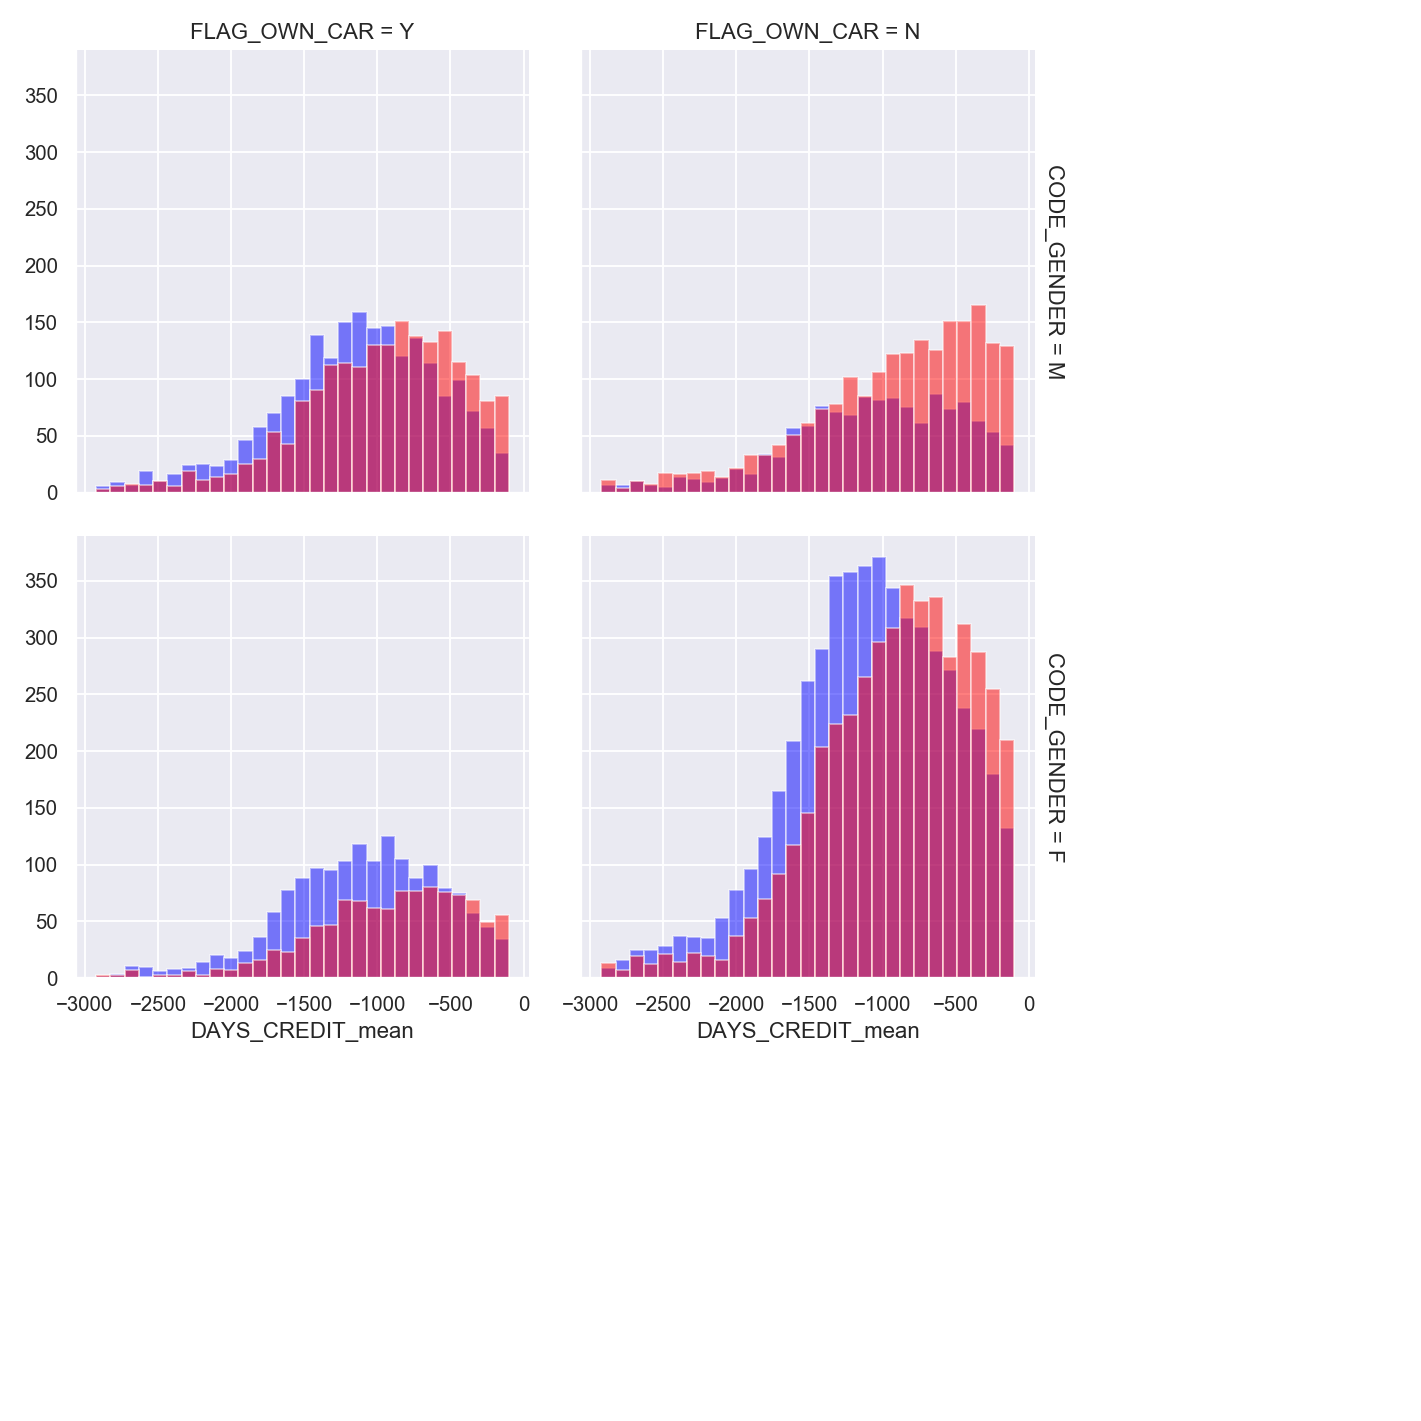

In [490]:
y_axs_feat = 'DAYS_CREDIT_mean'

g = sns.FacetGrid(this_sample, 
                  row = 'CODE_GENDER', 
                  col = 'FLAG_OWN_CAR', 
                  hue = 'TARGET',
                  palette = ['blue','red'],
                  height = 4,
                  margin_titles=True)

mn = min(this_sample[y_axs_feat])
mx = max(this_sample[y_axs_feat])

my_bins = np.arange(mn, mx, (mx-mn)/30)

g.map(plt.hist, y_axs_feat, bins = my_bins,**{'alpha':.5})

plt.tight_layout()

<IPython.core.display.Javascript object>


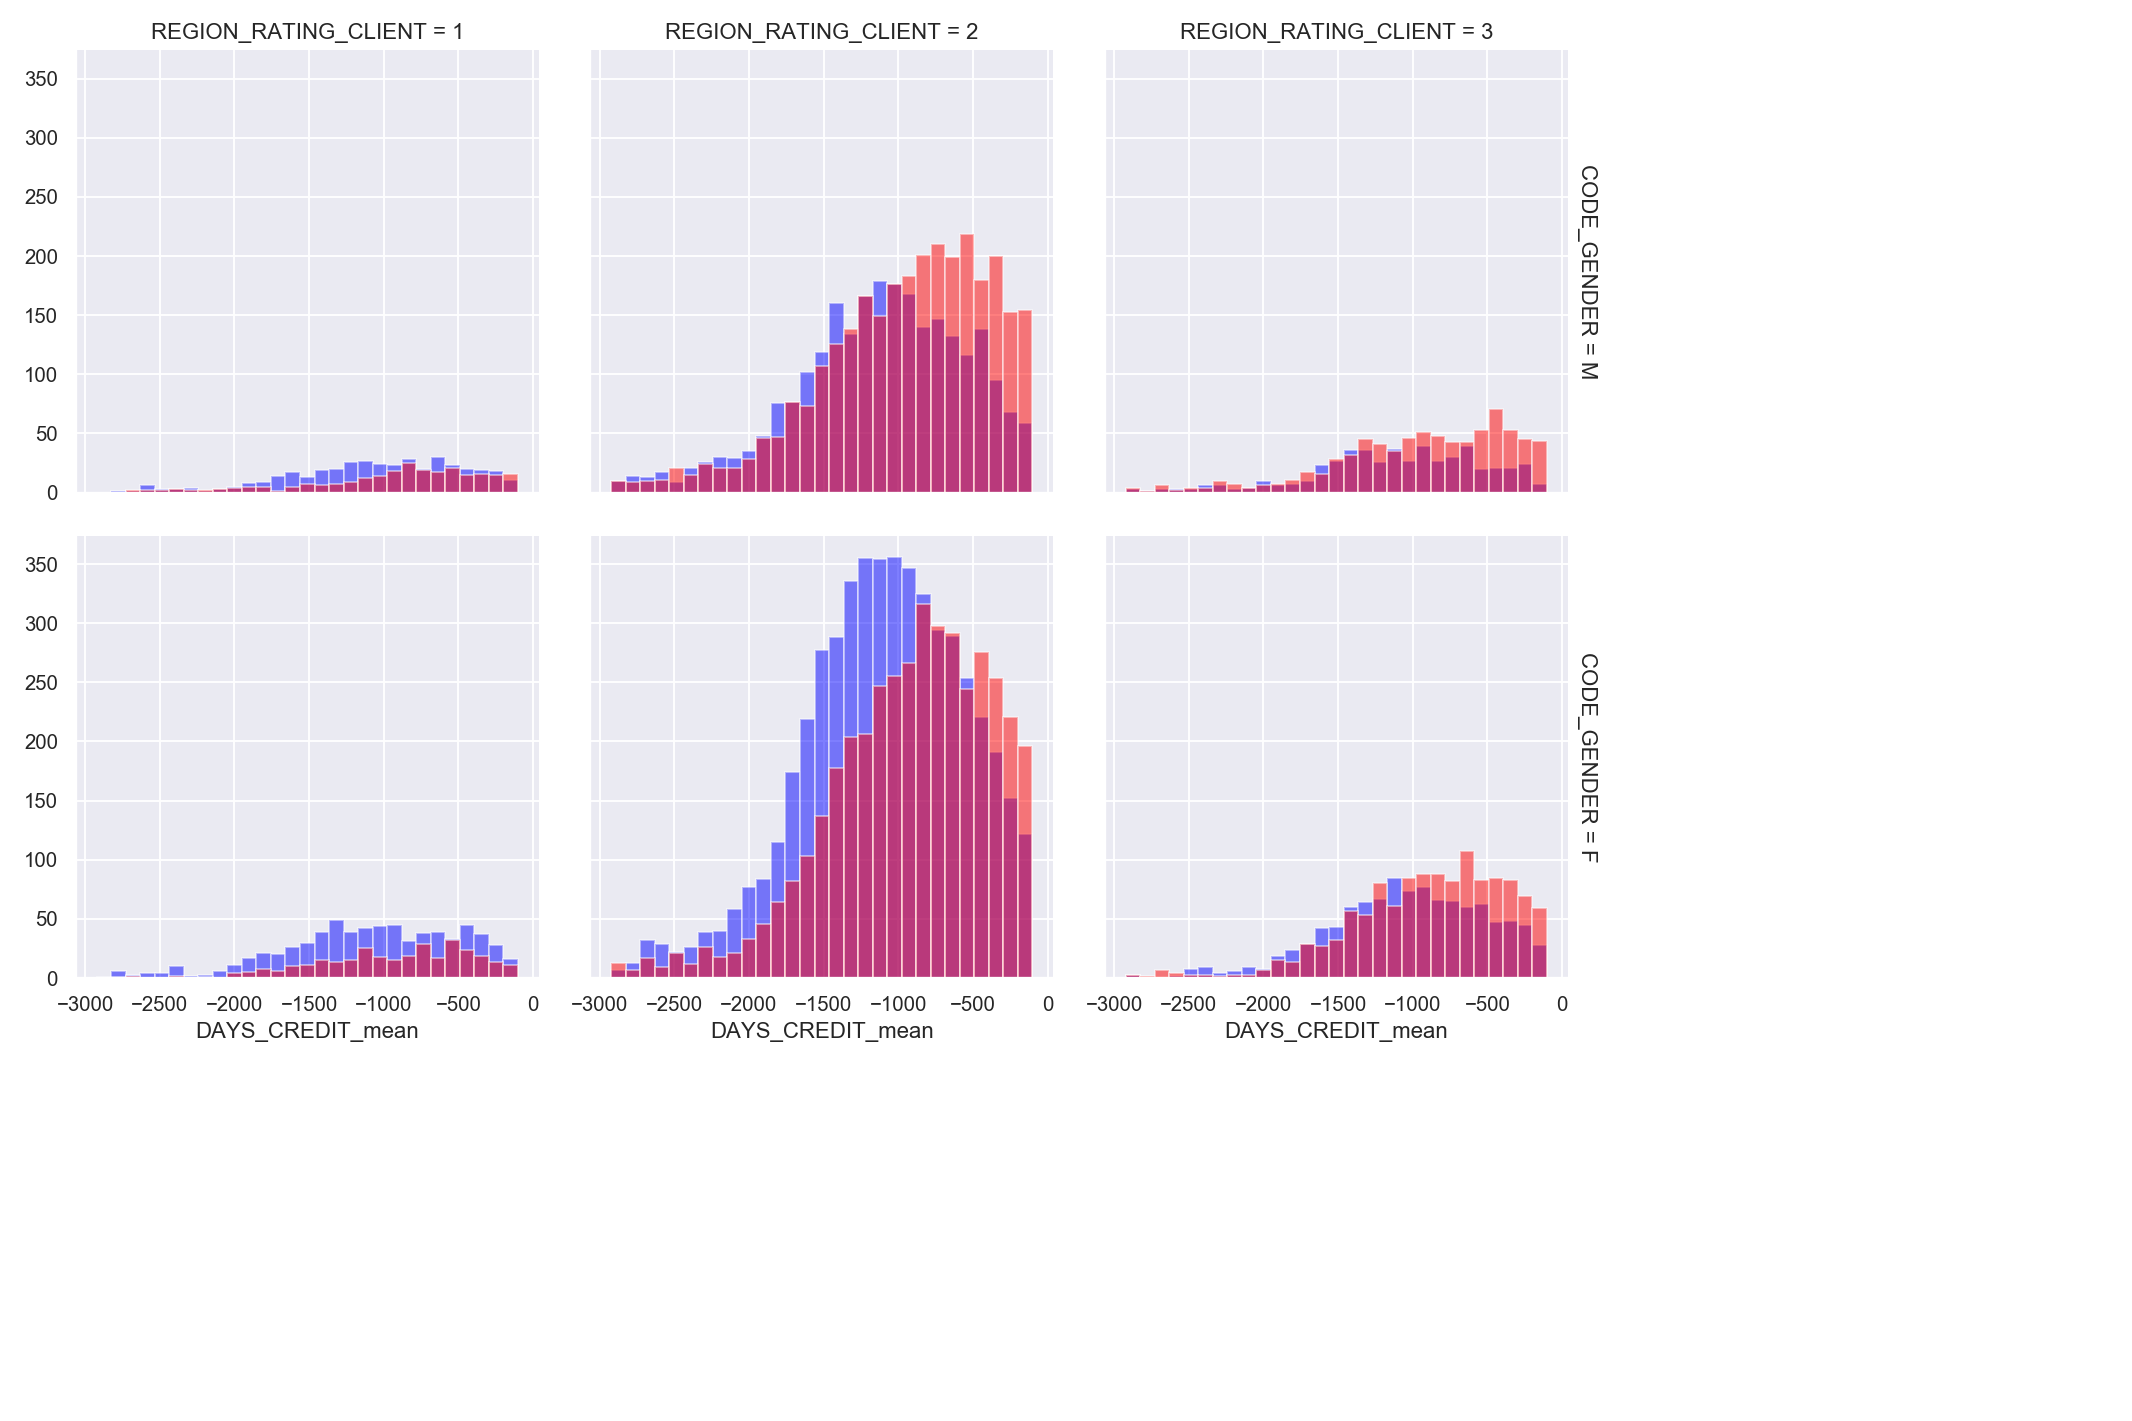

In [532]:
y_axs_feat = 'DAYS_CREDIT_mean'

g = sns.FacetGrid(this_sample, 
                  row = 'CODE_GENDER', 
                  col = 'REGION_RATING_CLIENT', 
                  hue = 'TARGET',
                  palette = ['blue','red'],
                  height = 4,
                  margin_titles=True)

mn = min(this_sample[y_axs_feat])
mx = max(this_sample[y_axs_feat])

my_bins = np.arange(mn, mx, (mx-mn)/30)

g.map(plt.hist, y_axs_feat, bins = my_bins,**{'alpha':.5})

plt.tight_layout()

<IPython.core.display.Javascript object>


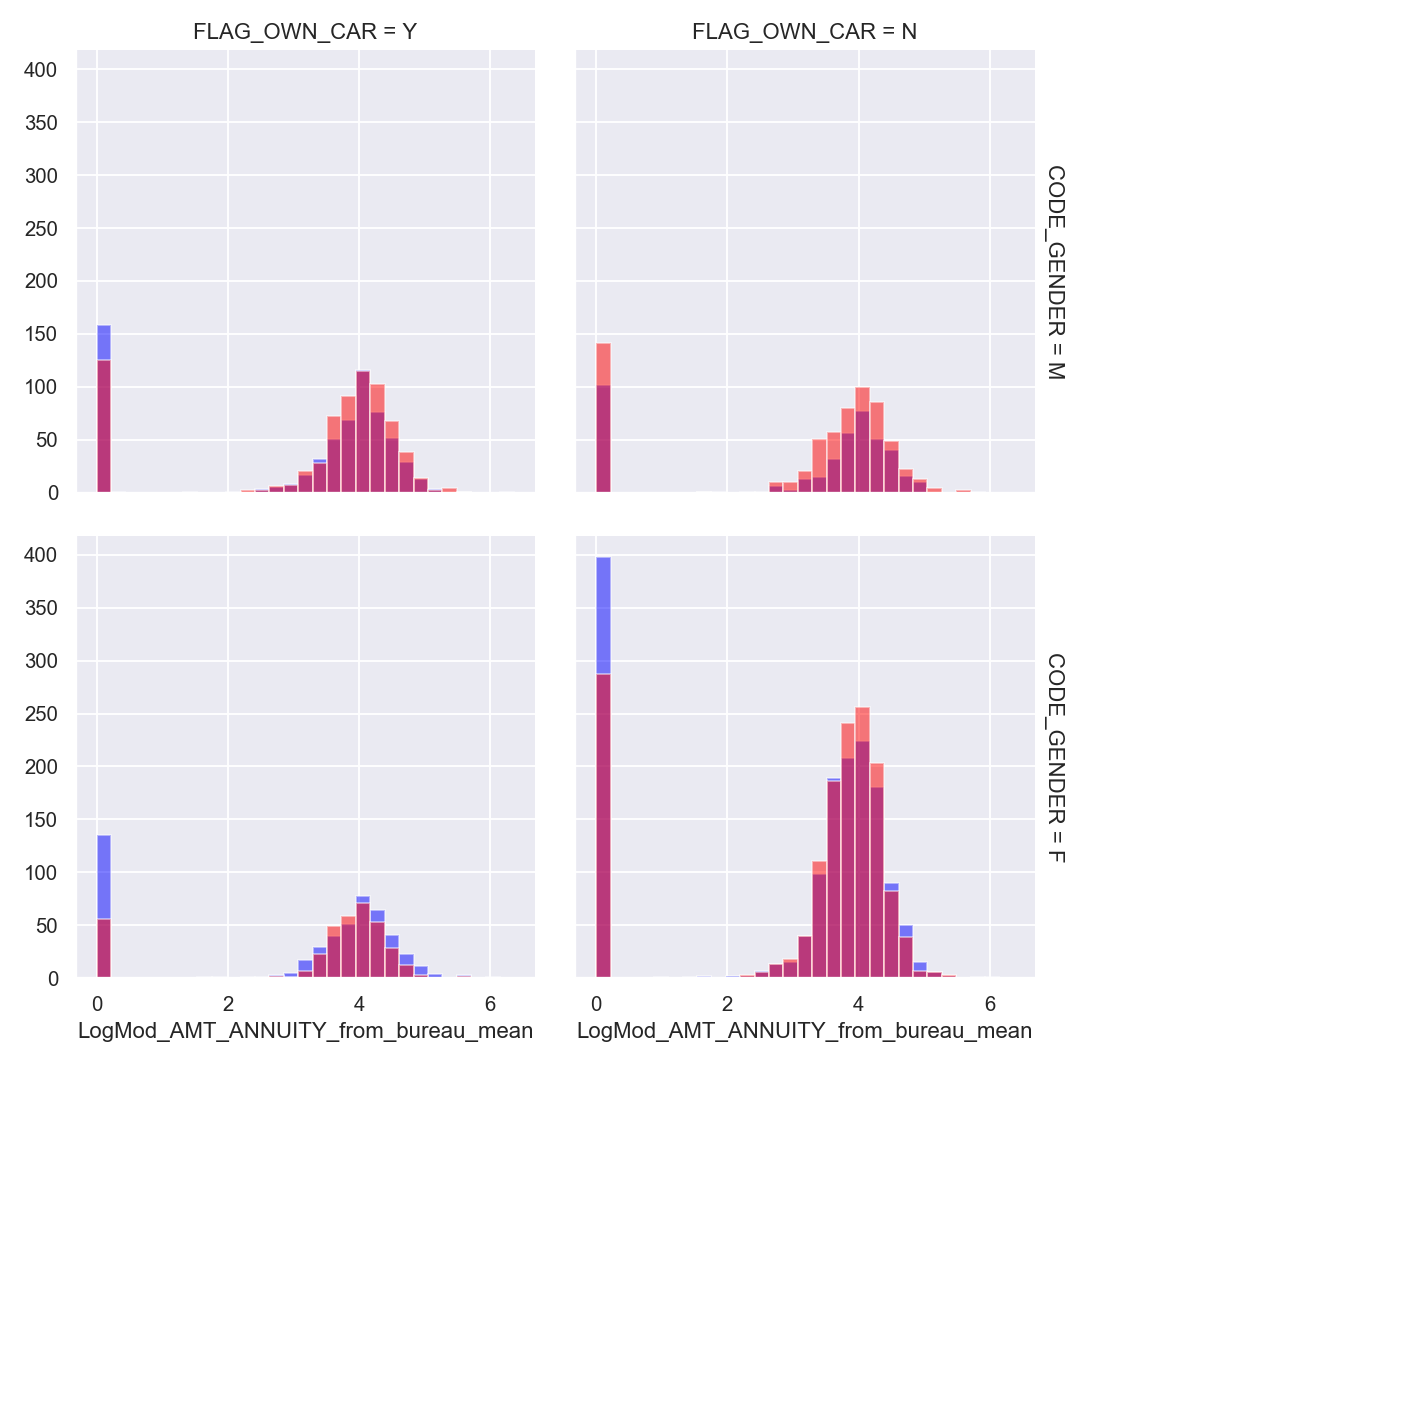

In [491]:
y_axs_feat = 'LogMod_AMT_ANNUITY_from_bureau_mean'

g = sns.FacetGrid(this_sample, 
                  row = 'CODE_GENDER', 
                  col = 'FLAG_OWN_CAR', 
                  hue = 'TARGET',
                  palette = ['blue','red'],
                  height = 4,
                  margin_titles=True)

mn = min(this_sample[y_axs_feat])
mx = max(this_sample[y_axs_feat])

my_bins = np.arange(mn, mx, (mx-mn)/30)

g.map(plt.hist, y_axs_feat, bins = my_bins,**{'alpha':.5})

plt.tight_layout()

<IPython.core.display.Javascript object>


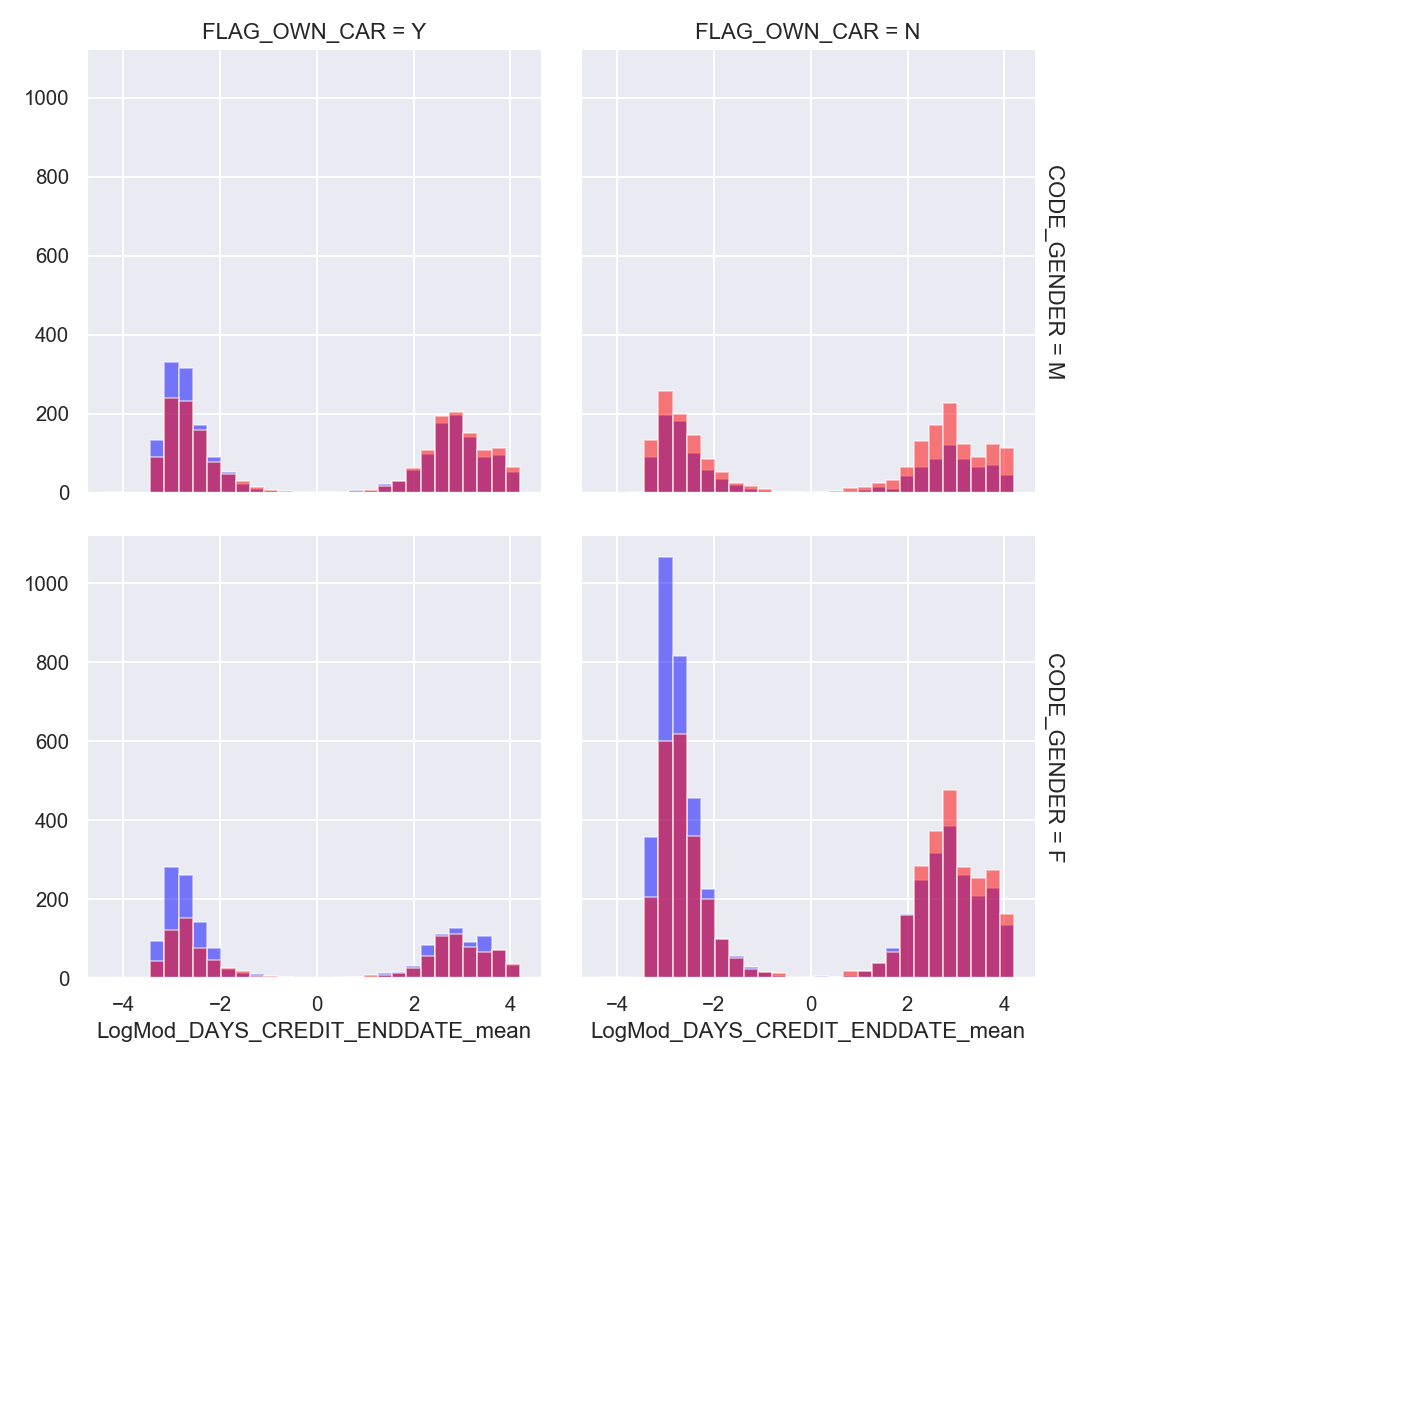

In [492]:
y_axs_feat = 'LogMod_DAYS_CREDIT_ENDDATE_mean'

g = sns.FacetGrid(this_sample, 
                  row = 'CODE_GENDER', 
                  col = 'FLAG_OWN_CAR', 
                  hue = 'TARGET',
                  palette = ['blue','red'],
                  height = 4,
                  margin_titles=True)

mn = min(this_sample[y_axs_feat])
mx = max(this_sample[y_axs_feat])

my_bins = np.arange(mn, mx, (mx-mn)/30)

g.map(plt.hist, y_axs_feat, bins = my_bins,**{'alpha':.5})

plt.tight_layout()

<IPython.core.display.Javascript object>


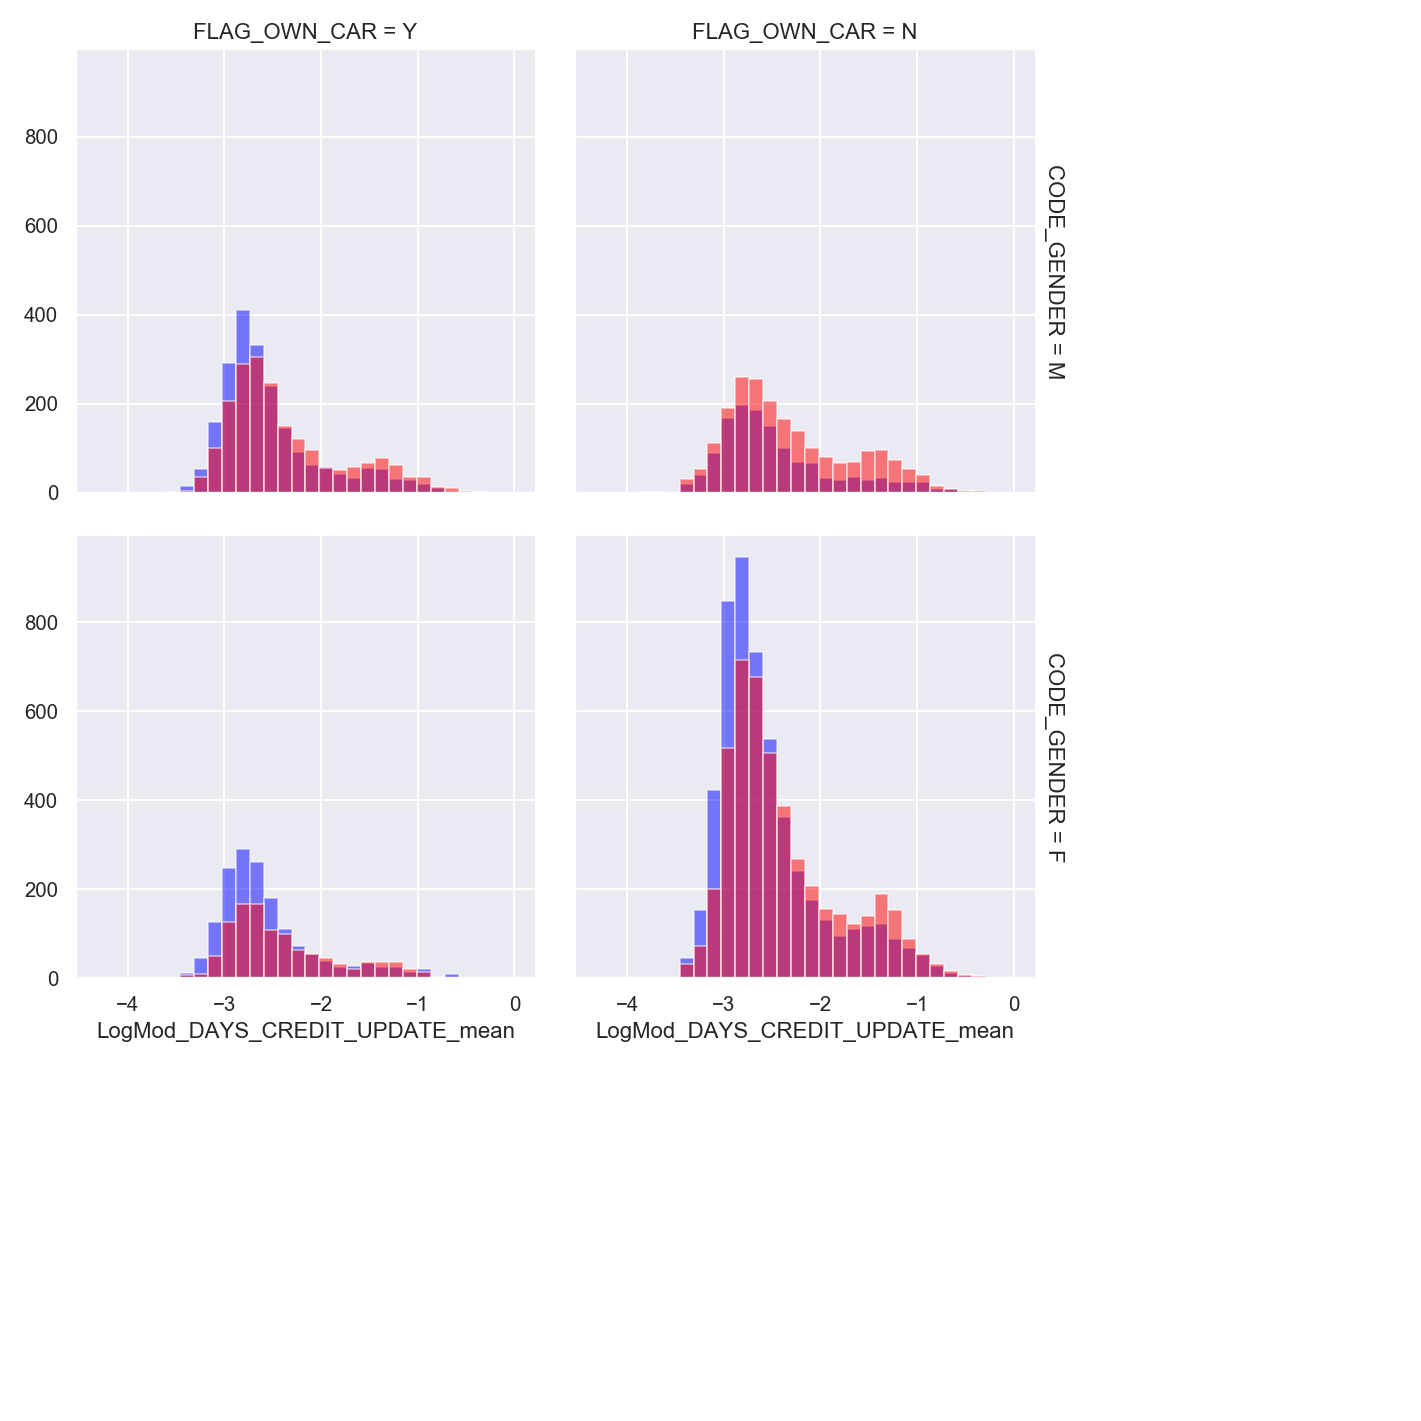

In [533]:
y_axs_feat = 'LogMod_DAYS_CREDIT_UPDATE_mean'

g = sns.FacetGrid(this_sample, 
                  row = 'CODE_GENDER', 
                  col = 'FLAG_OWN_CAR', 
                  hue = 'TARGET',
                  palette = ['blue','red'],
                  height = 4,
                  margin_titles=True)

mn = min(this_sample[y_axs_feat])
mx = max(this_sample[y_axs_feat])

my_bins = np.arange(mn, mx, (mx-mn)/30)

g.map(plt.hist, y_axs_feat, bins = my_bins,**{'alpha':.5})

plt.tight_layout()

### based on bureaus cats

<IPython.core.display.Javascript object>


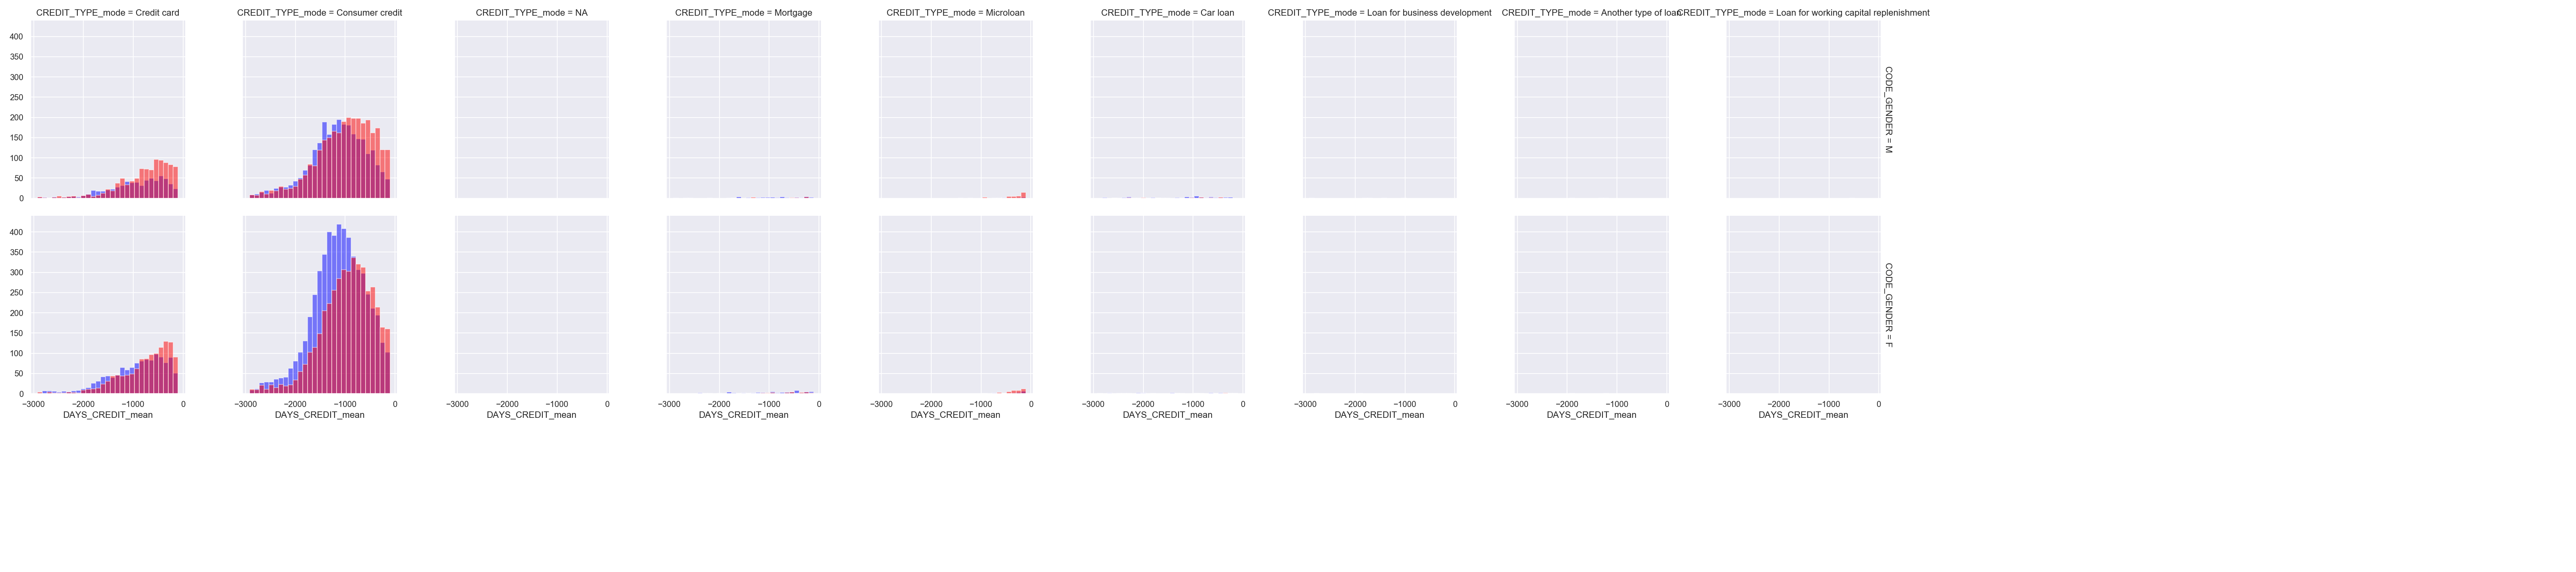

In [540]:
y_axs_feat = 'DAYS_CREDIT_mean'

g = sns.FacetGrid(this_sample, 
                  row = 'CODE_GENDER', 
                  col = 'CREDIT_TYPE_mode', 
                  hue = 'TARGET',
                  palette = ['blue','red'],
                  height = 4,
                  margin_titles=True)

mn = min(this_sample[y_axs_feat])
mx = max(this_sample[y_axs_feat])

my_bins = np.arange(mn, mx, (mx-mn)/30)

g.map(plt.hist, y_axs_feat, bins = my_bins,**{'alpha':.5})

plt.tight_layout()

<IPython.core.display.Javascript object>


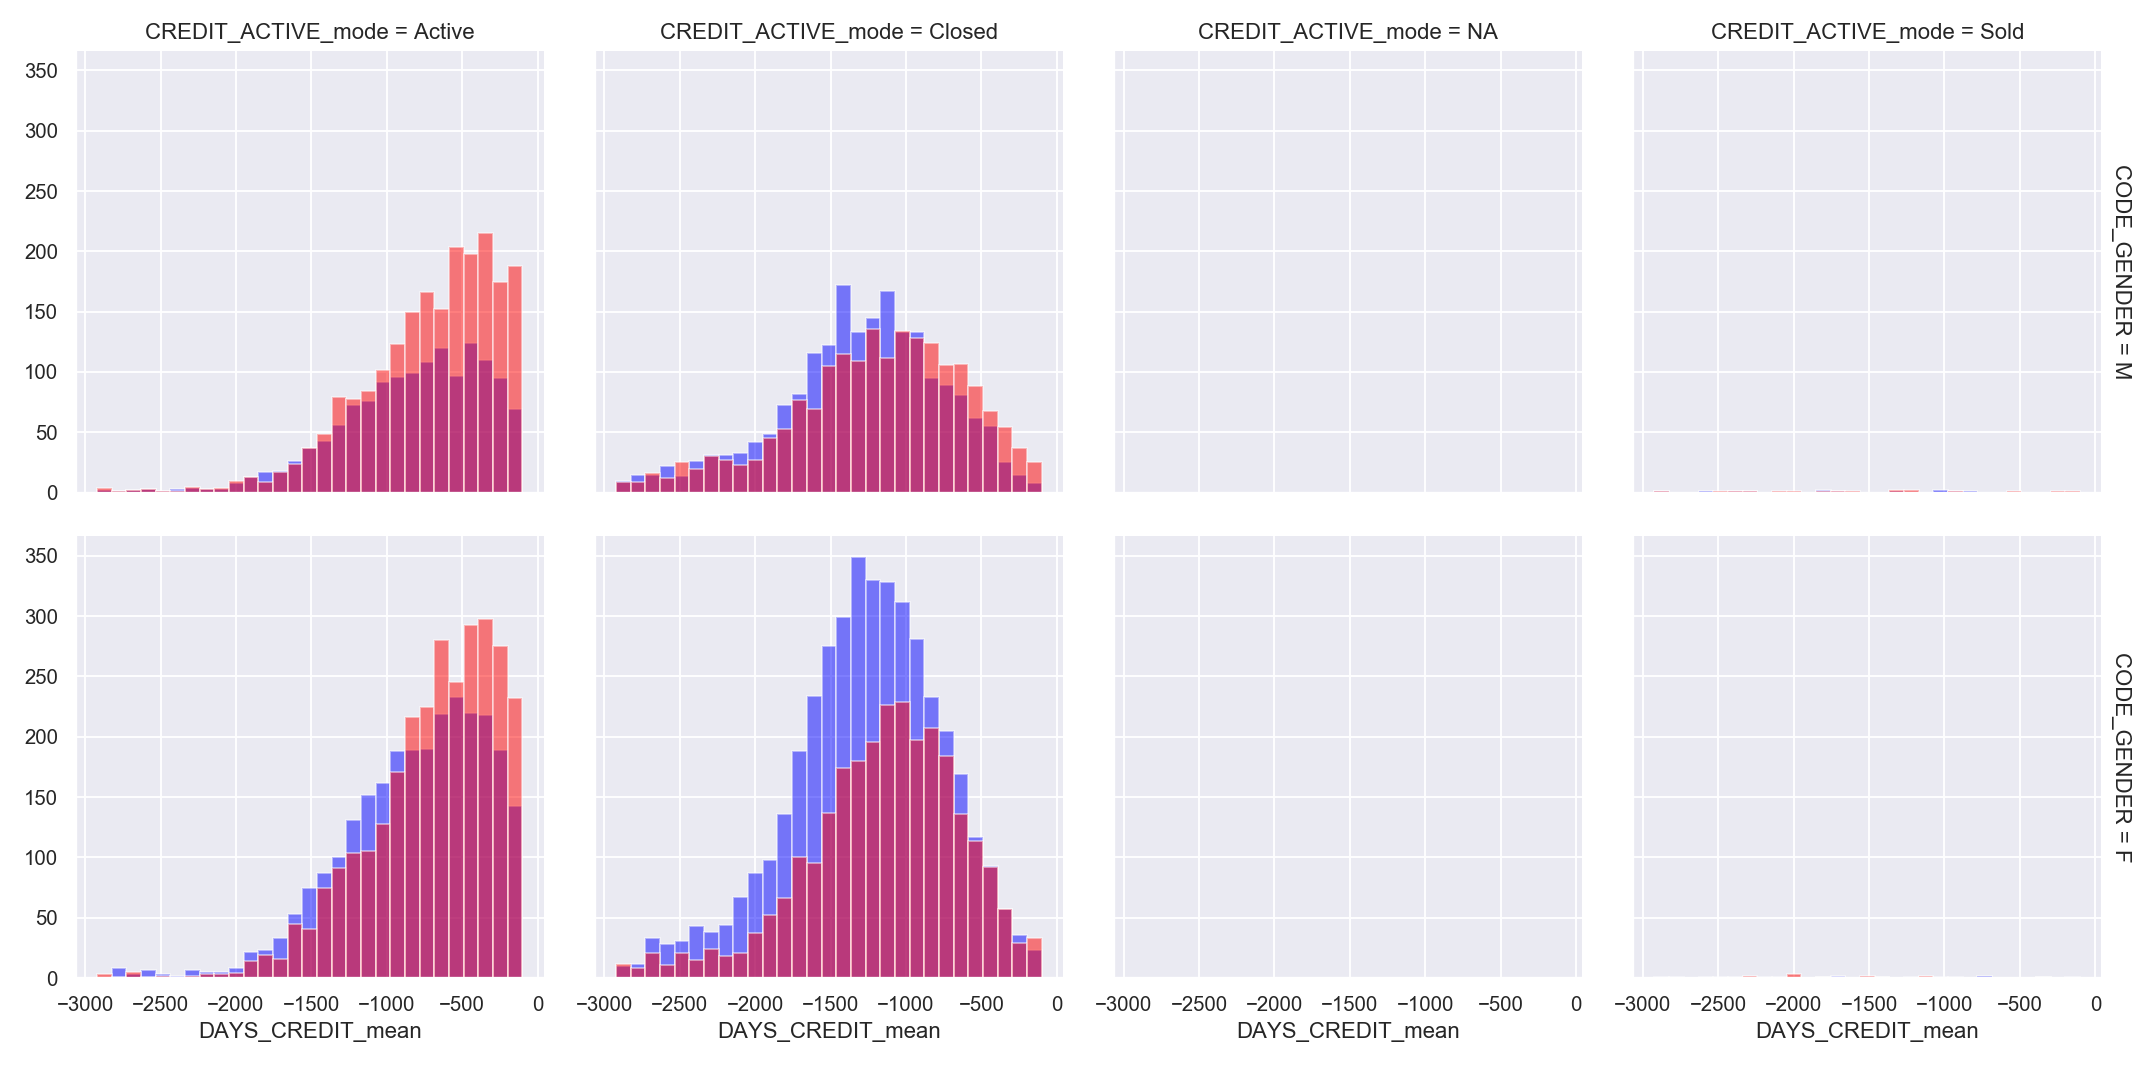

In [541]:
y_axs_feat = 'DAYS_CREDIT_mean'

g = sns.FacetGrid(this_sample, 
                  row = 'CODE_GENDER', 
                  col = 'CREDIT_ACTIVE_mode', 
                  hue = 'TARGET',
                  palette = ['blue','red'],
                  height = 4,
                  margin_titles=True)

mn = min(this_sample[y_axs_feat])
mx = max(this_sample[y_axs_feat])

my_bins = np.arange(mn, mx, (mx-mn)/30)

g.map(plt.hist, y_axs_feat, bins = my_bins,**{'alpha':.5})

plt.tight_layout()

<IPython.core.display.Javascript object>


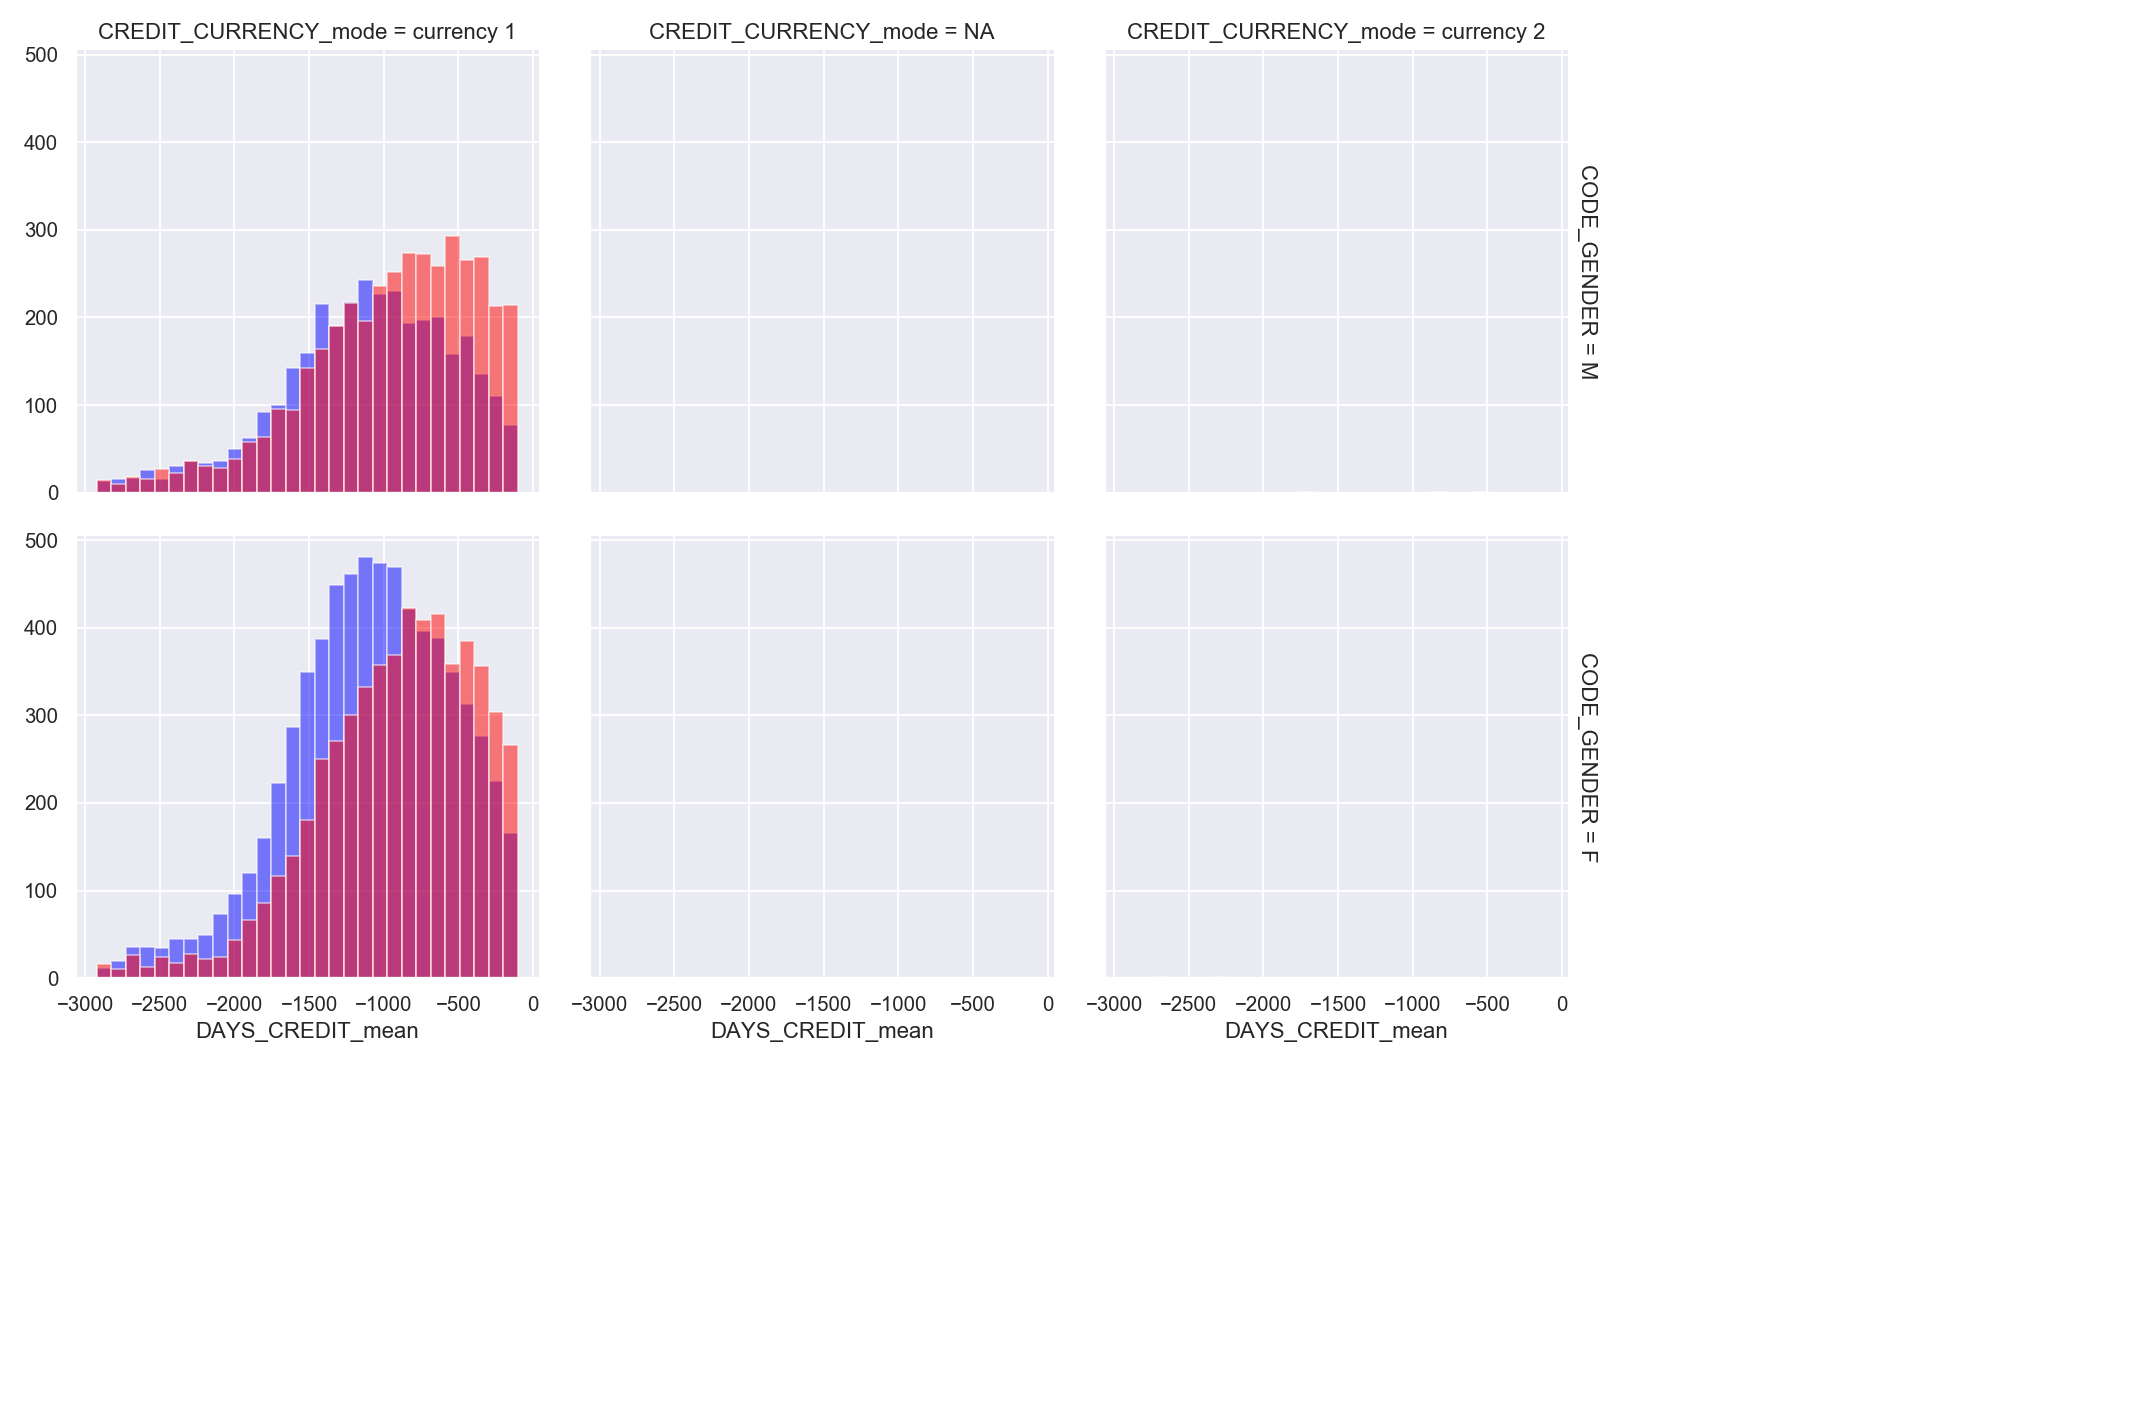

In [542]:
y_axs_feat = 'DAYS_CREDIT_mean'

g = sns.FacetGrid(this_sample, 
                  row = 'CODE_GENDER', 
                  col = 'CREDIT_CURRENCY_mode', 
                  hue = 'TARGET',
                  palette = ['blue','red'],
                  height = 4,
                  margin_titles=True)

mn = min(this_sample[y_axs_feat])
mx = max(this_sample[y_axs_feat])

my_bins = np.arange(mn, mx, (mx-mn)/30)

g.map(plt.hist, y_axs_feat, bins = my_bins,**{'alpha':.5})

plt.tight_layout()

/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


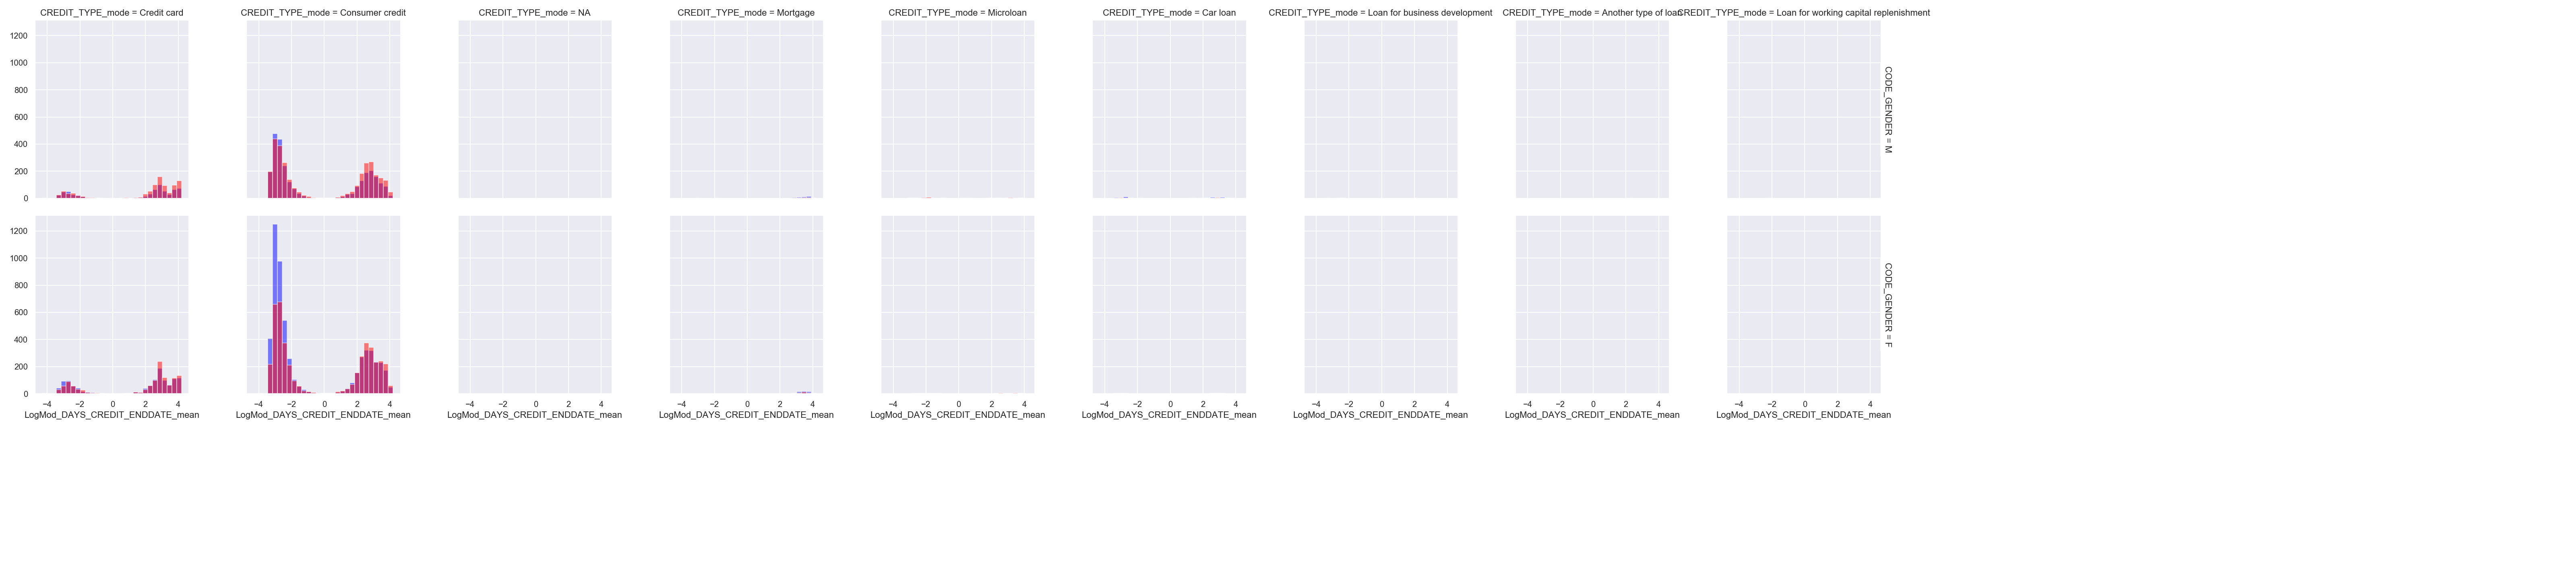

In [543]:
y_axs_feat = 'LogMod_DAYS_CREDIT_ENDDATE_mean'

g = sns.FacetGrid(this_sample, 
                  row = 'CODE_GENDER', 
                  col = 'CREDIT_TYPE_mode', 
                  hue = 'TARGET',
                  palette = ['blue','red'],
                  height = 4,
                  margin_titles=True)

mn = min(this_sample[y_axs_feat])
mx = max(this_sample[y_axs_feat])

my_bins = np.arange(mn, mx, (mx-mn)/30)

g.map(plt.hist, y_axs_feat, bins = my_bins,**{'alpha':.5})

plt.tight_layout()

/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


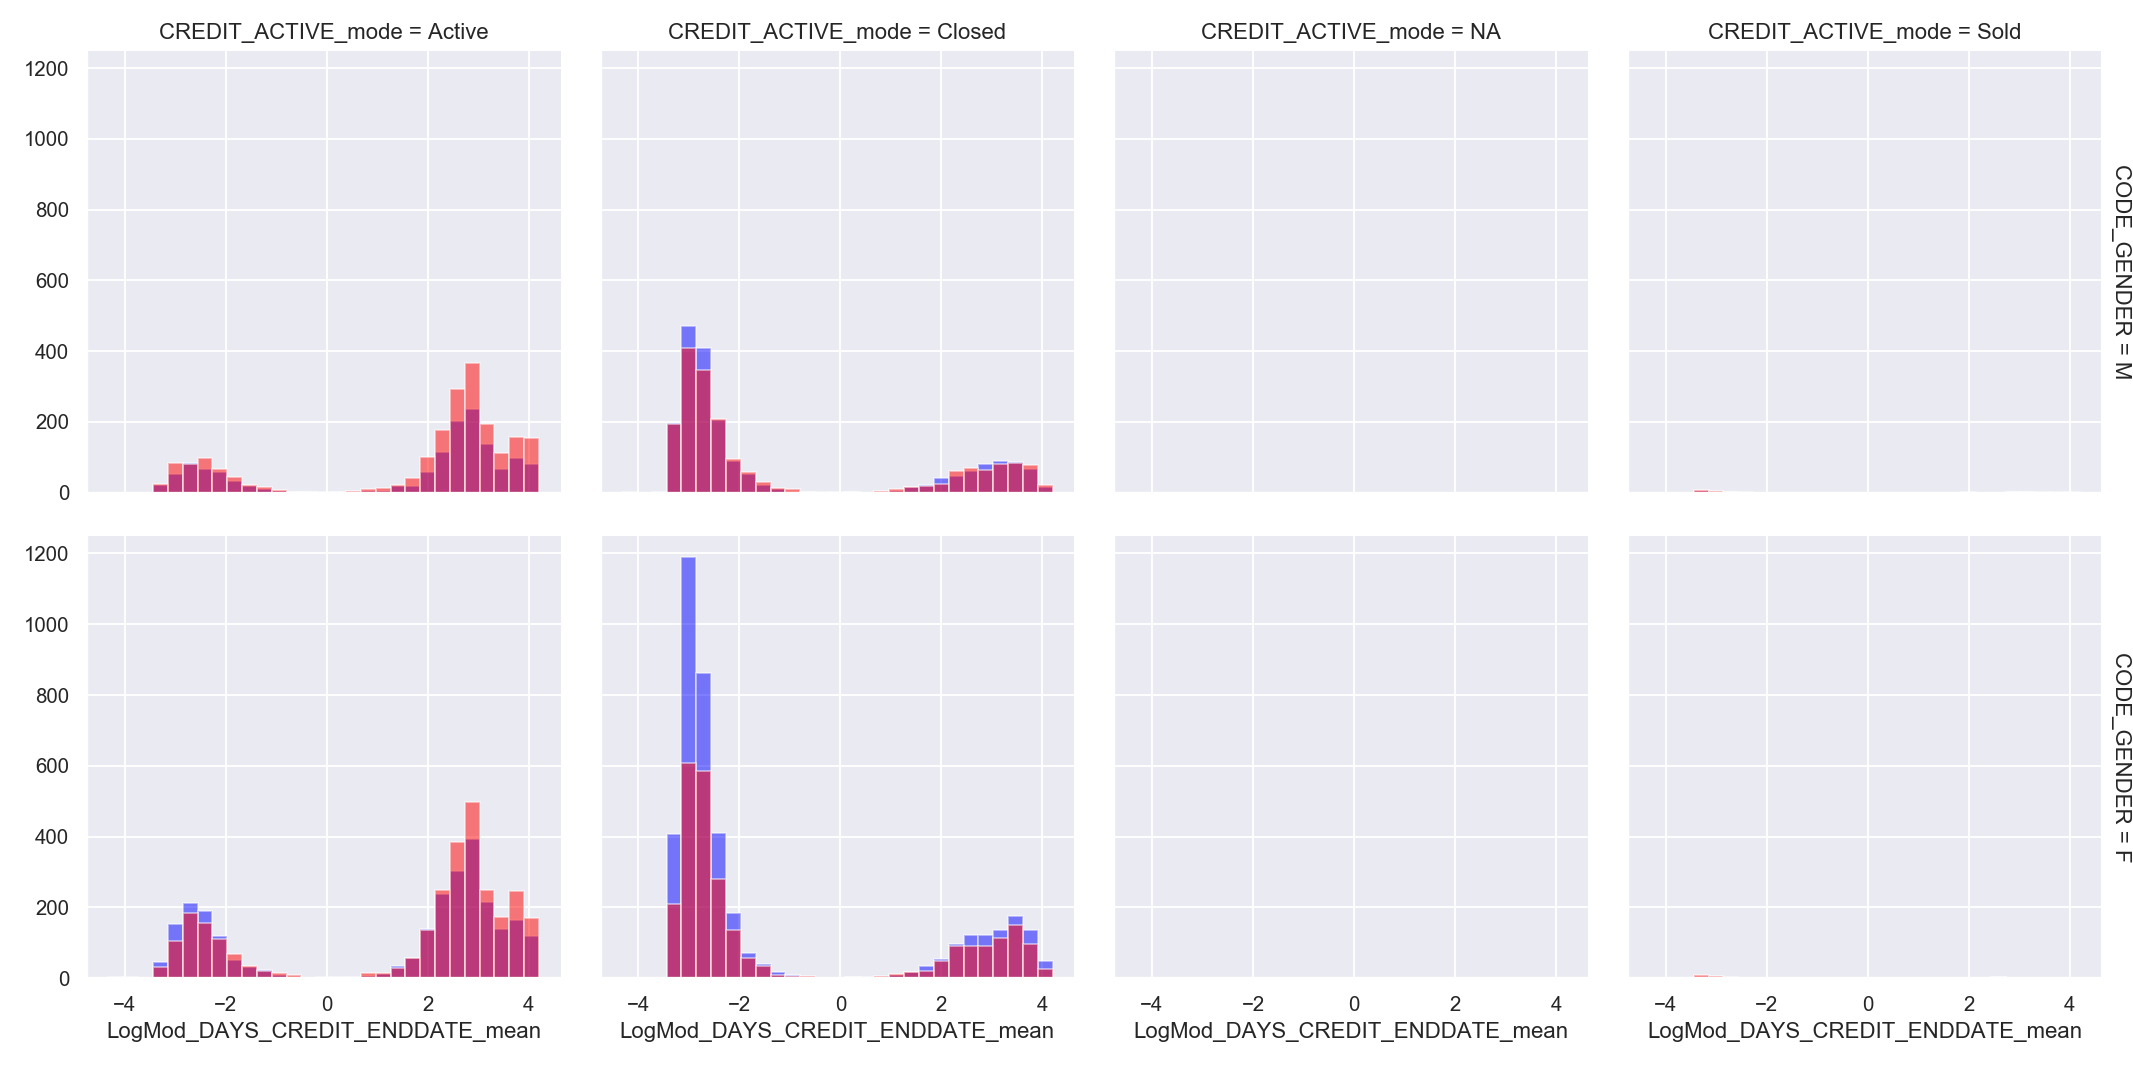

In [544]:
y_axs_feat = 'LogMod_DAYS_CREDIT_ENDDATE_mean'

g = sns.FacetGrid(this_sample, 
                  row = 'CODE_GENDER', 
                  col = 'CREDIT_ACTIVE_mode', 
                  hue = 'TARGET',
                  palette = ['blue','red'],
                  height = 4,
                  margin_titles=True)

mn = min(this_sample[y_axs_feat])
mx = max(this_sample[y_axs_feat])

my_bins = np.arange(mn, mx, (mx-mn)/30)

g.map(plt.hist, y_axs_feat, bins = my_bins,**{'alpha':.5})

plt.tight_layout()

/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


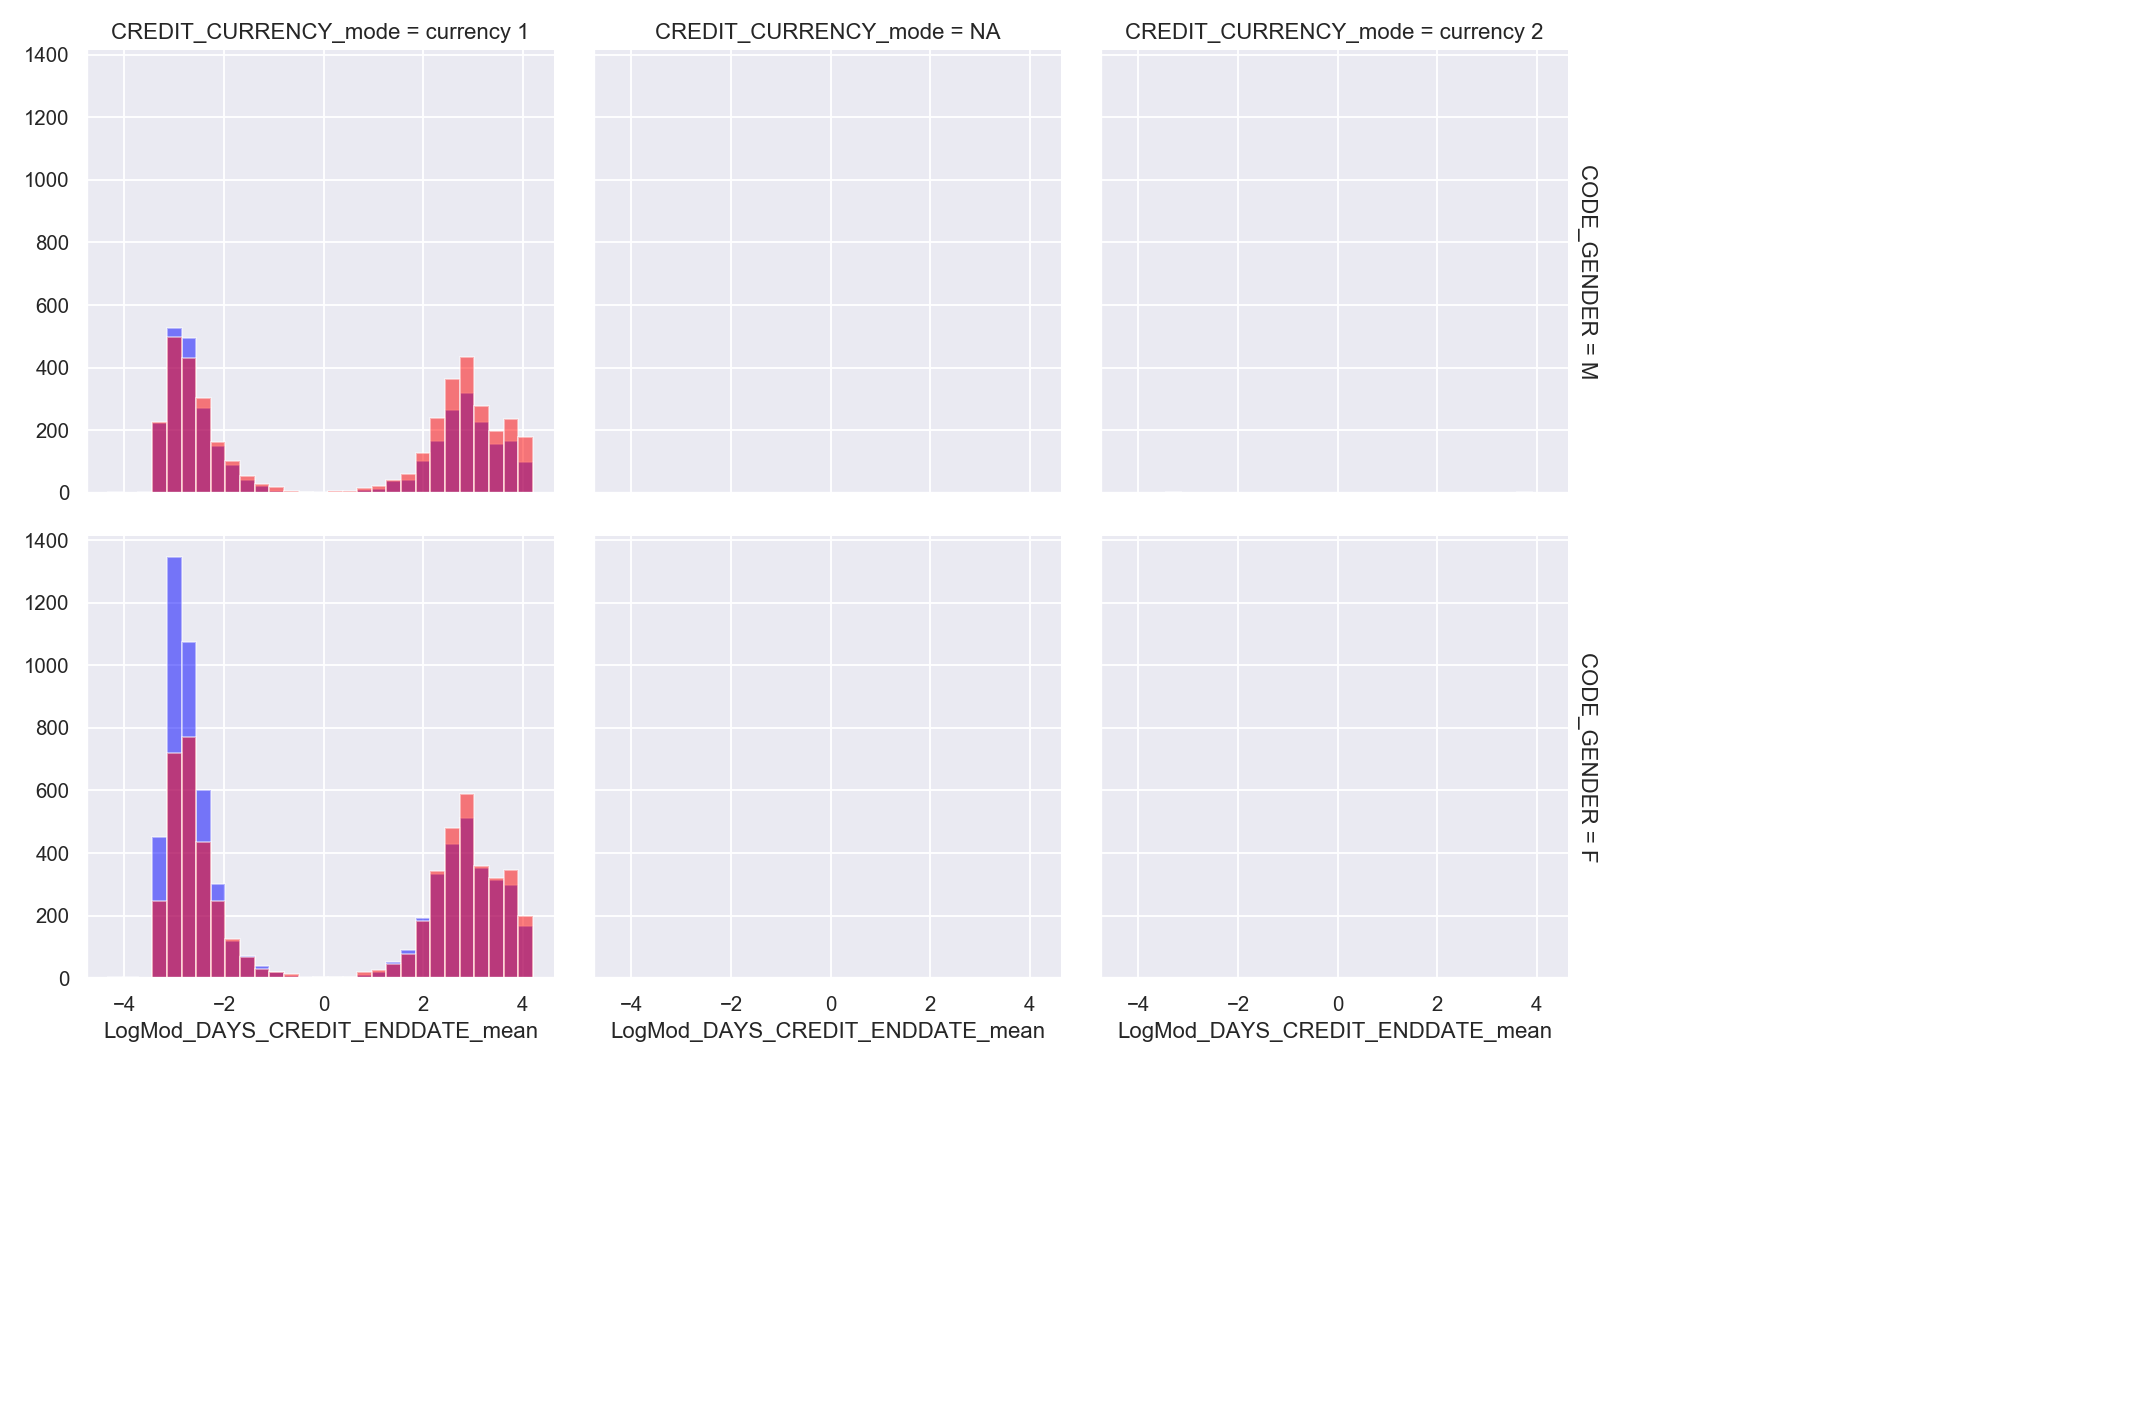

In [545]:
y_axs_feat = 'LogMod_DAYS_CREDIT_ENDDATE_mean'

g = sns.FacetGrid(this_sample, 
                  row = 'CODE_GENDER', 
                  col = 'CREDIT_CURRENCY_mode', 
                  hue = 'TARGET',
                  palette = ['blue','red'],
                  height = 4,
                  margin_titles=True)

mn = min(this_sample[y_axs_feat])
mx = max(this_sample[y_axs_feat])

my_bins = np.arange(mn, mx, (mx-mn)/30)

g.map(plt.hist, y_axs_feat, bins = my_bins,**{'alpha':.5})

plt.tight_layout()